In [1]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import ephem
import datetime
import numpy as np
import seaborn as sns
from scipy import signal
from IPython import display
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, DivergingNorm, SymLogNorm

sns.set()
sns.set_style("ticks")

In [3]:
from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.common_vars.directories import LUIGI_OUT_FOLDER,POSTPROCESS_OUT_FOLDER
from spectral_analysis.common_vars.regions import ids_regions,lats4id,lons4id,faces_regions
from spectral_analysis.luigi_workflows.output import theta4idt,Theta4id,uv4idt,UV4id,tau4idt,Tau4id,VorticityGrid,HF4id
from spectral_analysis.luigi_workflows.llc_region import LLCRegion

In [4]:
threads = 4

In [5]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S")

#logging.getLogger("matplotlib.font_manager").setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

In [6]:
cmap_ranges = {
    "KE": [1e-5,1e-2],
    "RV": [1e-12,1e-10],
    "DIV": [1e-12,1e-10],
    "RVDIV": [0.1,10]
}

In [7]:
xlims = [1/150,1/8]
xticks = [1/10,1/25,1/50,1/80,1/150]
xticksLabel = ['10','25','50','80','150']
yticks = [1/3,1/6,1/12,1/24,1/(24*7),1/(24*30)]
yticksLabel = ['3 h','6 h','12 h','1 d','1 w','1 mo']
# Lt plots
xticks_ = [1/10,1/20,1/30,1/40,1/50,1/75,1/100,1/150]
xticksLabel_ = ['10','20','30','40','50','75','100','150']

In [8]:
def plot_spectra(ki, omega, S, title, cmap='nipy_spectral_r', vminmax=None, bottom=False):
    logging.info("{} - {}, {}, {}".format(title, S.shape, omega.shape, ki.shape))
    #plt.figure(figsize=(8,6))
    #ki = ki[:-1]
    SS = (omega*S).T*ki
    if vminmax is None:
        vminmax = max(abs(np.min(SS)), np.max(SS))
    plt.pcolormesh(ki, omega, SS, norm = LogNorm(), cmap=cmap)
    plt.clim(vminmax)
    plt.xscale('log')
    plt.xticks(xticks,xticksLabel)
    plt.xlim(xlims)
    plt.yscale('log')
    plt.ylim([omega[1],omega[-100]])
    plt.yticks(yticks,yticksLabel)
    plt.colorbar()
    if bottom:
      plt.xlabel('Horizontal scales [km]', size='large')
    plt.ylabel('Time scales', size='large')
    plt.title(title, size='x-large')
    #plt.show()

In [12]:
def plot_cospectra(ki, omega, S, title, linthresh=5e-2, cmap='bwr', vminmax=None, bottom=False):
    logging.info("{} - {} (type={}), {} (type={}), {} (type={})".format(title, S.shape, S.dtype, omega.shape, omega.dtype, ki.shape, ki.dtype))
    #plt.figure(figsize=(8,6))
    SS = (omega*S).T*ki
    if vminmax is None:
        vminmax = max(abs(np.min(SS)), np.max(SS))
    norm = SymLogNorm(linthresh=linthresh, vmin=-1*vminmax, vmax=vminmax)
    #norm = DivergingNorm(vmin=-1*vminmax, vmax=vminmax, vcenter=0)
    plt.pcolormesh(ki, omega, SS, norm=norm, cmap=cmap)
    #plt.clim(cmap_ranges["KE"])
    plt.xscale('log')
    plt.xticks(xticks,xticksLabel)
    plt.xlim(xlims)
    plt.yscale('log')
    plt.ylim([omega[1],omega[-100]])
    plt.yticks(yticks,yticksLabel)
    plt.colorbar()
    if bottom:
      plt.xlabel('Horizontal scales [km]', size='large')
    plt.ylabel('Time scales', size='large')
    plt.title(title, size='x-large')
    #plt.show()

In [10]:
def plotRegion(regionId):
    # Plot
    fig, ax = plt.subplots(11, 2, figsize=(16,50))
    ax = ax.flat[:]
        
    for idxS, season in enumerate(["ASO", "JFM"]):
        logging.info("Plotting: {} {}".format(regionId, season))
        timevec = idx_t["hours"][season]
        
        # Load vars
        region = LLCRegion(regionId, timevec, tag=season, threads=threads)
        region.loadScalar("oceQnet")
        region.loadHorizontalVector("U", "V", "uv")
        region.loadHorizontalVector("oceTAUX", "oceTAUY", "tau")
        region.norm("tau", "tau_norm")
        region.hcurl("tau", "tau_curl")
        region.hcurl("uv", "uv_curl")
        region.divergence("uv", "uv_div")
        
        # 
        region.power_spectrum_2d("uv", "KE")
        region.power_spectrum_2d("tau", "Tau")
        region.power_spectrum_1d("tau_norm", "Tau_norm")
        region.power_spectrum_1d("tau_curl", "Tau_curl")
        region.power_spectrum_1d("uv_curl", "RV")
        region.power_spectrum_1d("uv_div", "DIV")
        region.power_spectrum_1d("oceQnet", "Qnet")
        region.cospectrum("oceQnet", "uv_curl", "Qnet_RV_cospec")
        region.cospectrum("oceQnet", "uv_div", "Qnet_DIV_cospec")
        region.cospectrum("tau_norm", "uv_curl", "Tau_RV_cospec")
        region.cospectrum("tau_norm", "uv_div", "Tau_DIV_cospec")
        region.cospectrum("tau_curl", "uv_curl", "rotTau_RV_cospec")
        region.cospectrum("tau_curl", "uv_div", "rotTau_DIV_cospec")
        region.coherence("oceQnet", "uv_curl", "Qnet_RV_coh")
        region.coherence("oceQnet", "uv_div", "Qnet_DIV_coh")
        region.coherence("tau_norm", "uv_curl", "Tau_RV_coh")
        region.coherence("tau_norm", "uv_div", "Tau_DIV_coh")
        region.coherence("tau_curl", "uv_curl", "rotTau_RV_coh")
        region.coherence("tau_curl", "uv_div", "rotTau_DIV_coh")
        
        # 
        logging.info("All spectra - {}".format(region.get_spectra_names()))
        region.save_spectra()
        
        # Get vars
        ki = region.get_spectrum("k_h")
        logging.info("K: ({}, {})".format(np.min(ki), np.max(ki)))
        omega = region.get_spectrum("om")
        logging.info("omega: ({}, {})".format(np.min(omega), np.max(omega)))
        rv_spec = ((region.get_spectrum("RV").T)).T
        div_spec = ((region.get_spectrum("DIV").T)).T
        tau_spec = region.get_spectrum("Tau")
        tau_curl_spec = region.get_spectrum("Tau_curl")
        qnet_spec = region.get_spectrum("Qnet")
        co_qfluxRV_iso = region.get_spectrum("Qnet_RV_coh")
        #cospec_qfluxRV_iso = region.get_spectrum("Qnet_RV_cospec")
        co_qfluxDIV_iso = region.get_spectrum("Qnet_DIV_coh")
        co_rv_iso = region.get_spectrum("Tau_RV_coh")
        co_div_iso = region.get_spectrum("Tau_DIV_coh")
        co_rvRottau_iso = region.get_spectrum("rotTau_RV_coh")
        co_divrotTau_iso = region.get_spectrum("rotTau_DIV_coh")
        
        ## Spectrum -- KE_DIV, KE_RV
        plt.sca(ax[0+idxS])
        plot_spectra(ki, omega, rv_spec, "RV - {} ({})".format(regionId, season),vminmax=[1e-13,1e-10])
        plt.sca(ax[2+idxS])
        plot_spectra(ki, omega, div_spec, "DIV - {} ({})".format(regionId, season), vminmax=[1e-13,1e-10])
        
        ## Spectrum -- Tau, rot(Tau)
        plt.sca(ax[4+idxS])
        plot_spectra(ki, omega, tau_spec, "Tau - {} ({})".format(regionId, season), vminmax=[1e-8,1e-5])
        plt.sca(ax[6+idxS])
        plot_spectra(ki, omega, tau_curl_spec, "rot(Tau) - {} ({})".format(regionId, season), vminmax=[1e-16,1e-14])
        
        ## Spectrum -- oceQnet
        plt.sca(ax[8+idxS])
        plot_spectra(ki, omega, qnet_spec, "Qnet - {} ({})".format(regionId, season), vminmax=[1e-1,1e3])

        ## Cospectra oceQnet - RV/DIV
        plt.sca(ax[10+idxS])
        plot_cospectra(ki, omega, co_qfluxRV_iso, "cospec: oceQnet - RV - {} ({})".format(regionId, season), vminmax=1)
        plt.sca(ax[12+idxS])
        plot_cospectra(ki, omega, co_qfluxDIV_iso, "coh: oceQnet - DIV - {} ({})".format(regionId, season), vminmax=1)

        ## Cospectra tau - RV/DIV
        plt.sca(ax[14+idxS])
        plot_cospectra(ki, omega, co_rv_iso, "coh: RV - |Tau| - {} ({})".format(regionId, season), vminmax=1)
        plt.sca(ax[16+idxS])
        plot_cospectra(ki, omega, co_div_iso, "coh: DIV - |Tau| - {} ({})".format(regionId, season), vminmax=1)

        ## Cospectra rot(tau) - RV/DIV
        plt.sca(ax[18+idxS])
        plot_cospectra(ki, omega, co_rvRottau_iso, "coh: RV - rot(Tau) - {} ({})".format(regionId, season), vminmax=1)
        plt.sca(ax[20+idxS])
        plot_cospectra(ki, omega, co_divrotTau_iso, "coh: DIV - rot(Tau) - {} ({})".format(regionId, season), bottom=True, vminmax=1)
    
    plt.show()

In [11]:
def calc_cospectra(current):
    for rid in ids_regions[current]:
        try:
            plotRegion(rid)
        except Exception as err:
            print(err)

2021-03-10 10:09:04 INFO     Plotting: 762 ASO
2021-03-10 10:09:05 INFO     Grid: dx = 1.9028209215277783 km, dy = 2.0694956027777773 km, dt = 1 h
2021-03-10 10:09:05 INFO     Exists? 762: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/762_ASO_hours.npz
2021-03-10 10:09:06 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-03-10 10:09:06 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2021-03-10 10:09:50 INFO     Loading U: shape (k=0): (288, 289, 2208)
2021-03-10 10:10:32 INFO     Loading V: shape (k=0): (288, 289, 2208)
2021-03-10 10:11:14 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2021-03-10 10:12:00 INFO     Loading oceT

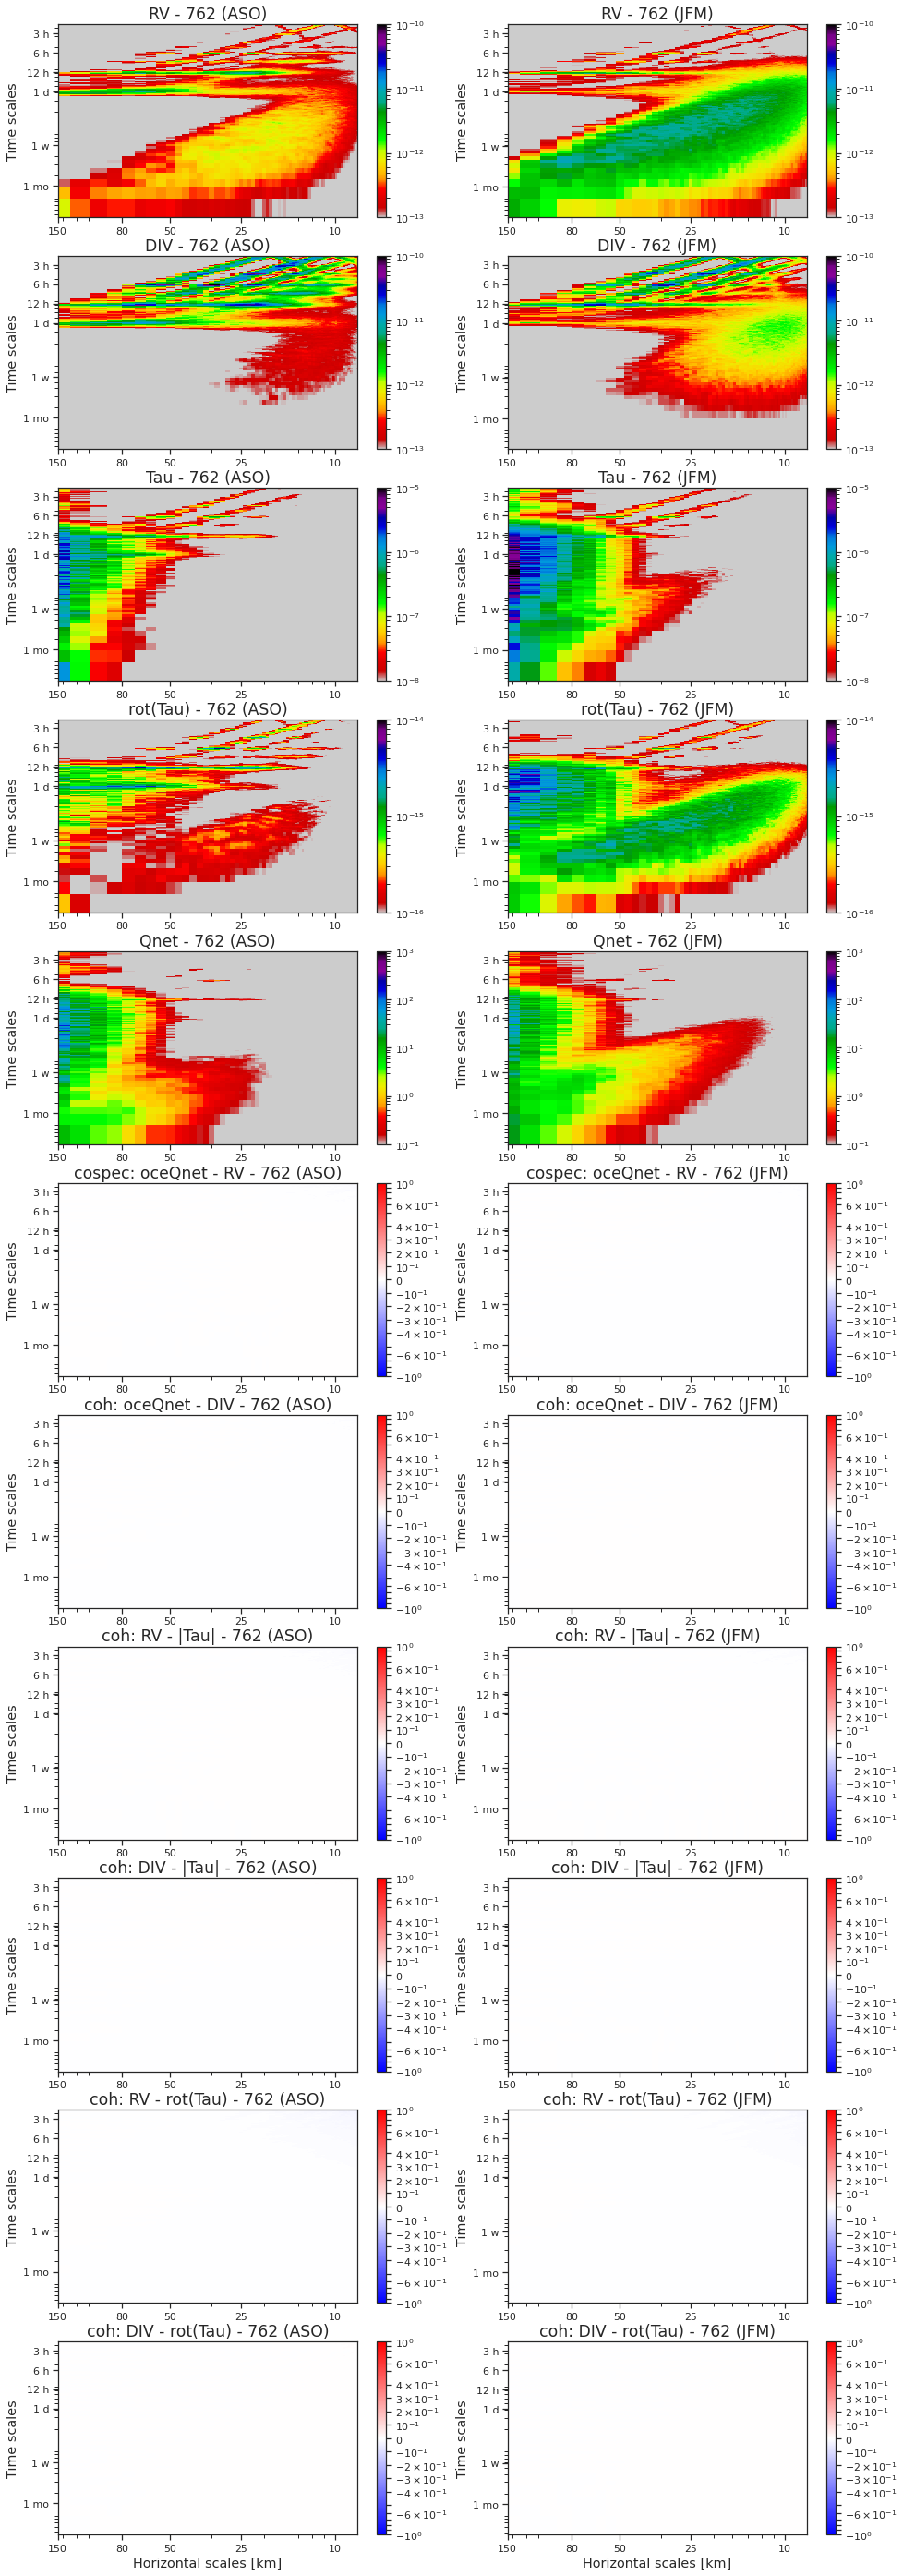

In [13]:
calc_cospectra("California")

2021-03-10 16:09:11 INFO     Plotting: 750 ASO
2021-03-10 16:09:12 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2021-03-10 16:09:12 INFO     Exists? 750: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/750_ASO_hours.npz
2021-03-10 16:09:13 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-03-10 16:09:13 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2021-03-10 16:10:03 INFO     Loading U: shape (k=0): (288, 289, 2208)
2021-03-10 16:10:49 INFO     Loading V: shape (k=0): (288, 289, 2208)
2021-03-10 16:11:36 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2021-03-10 16:12:25 INFO     Loading oceTA

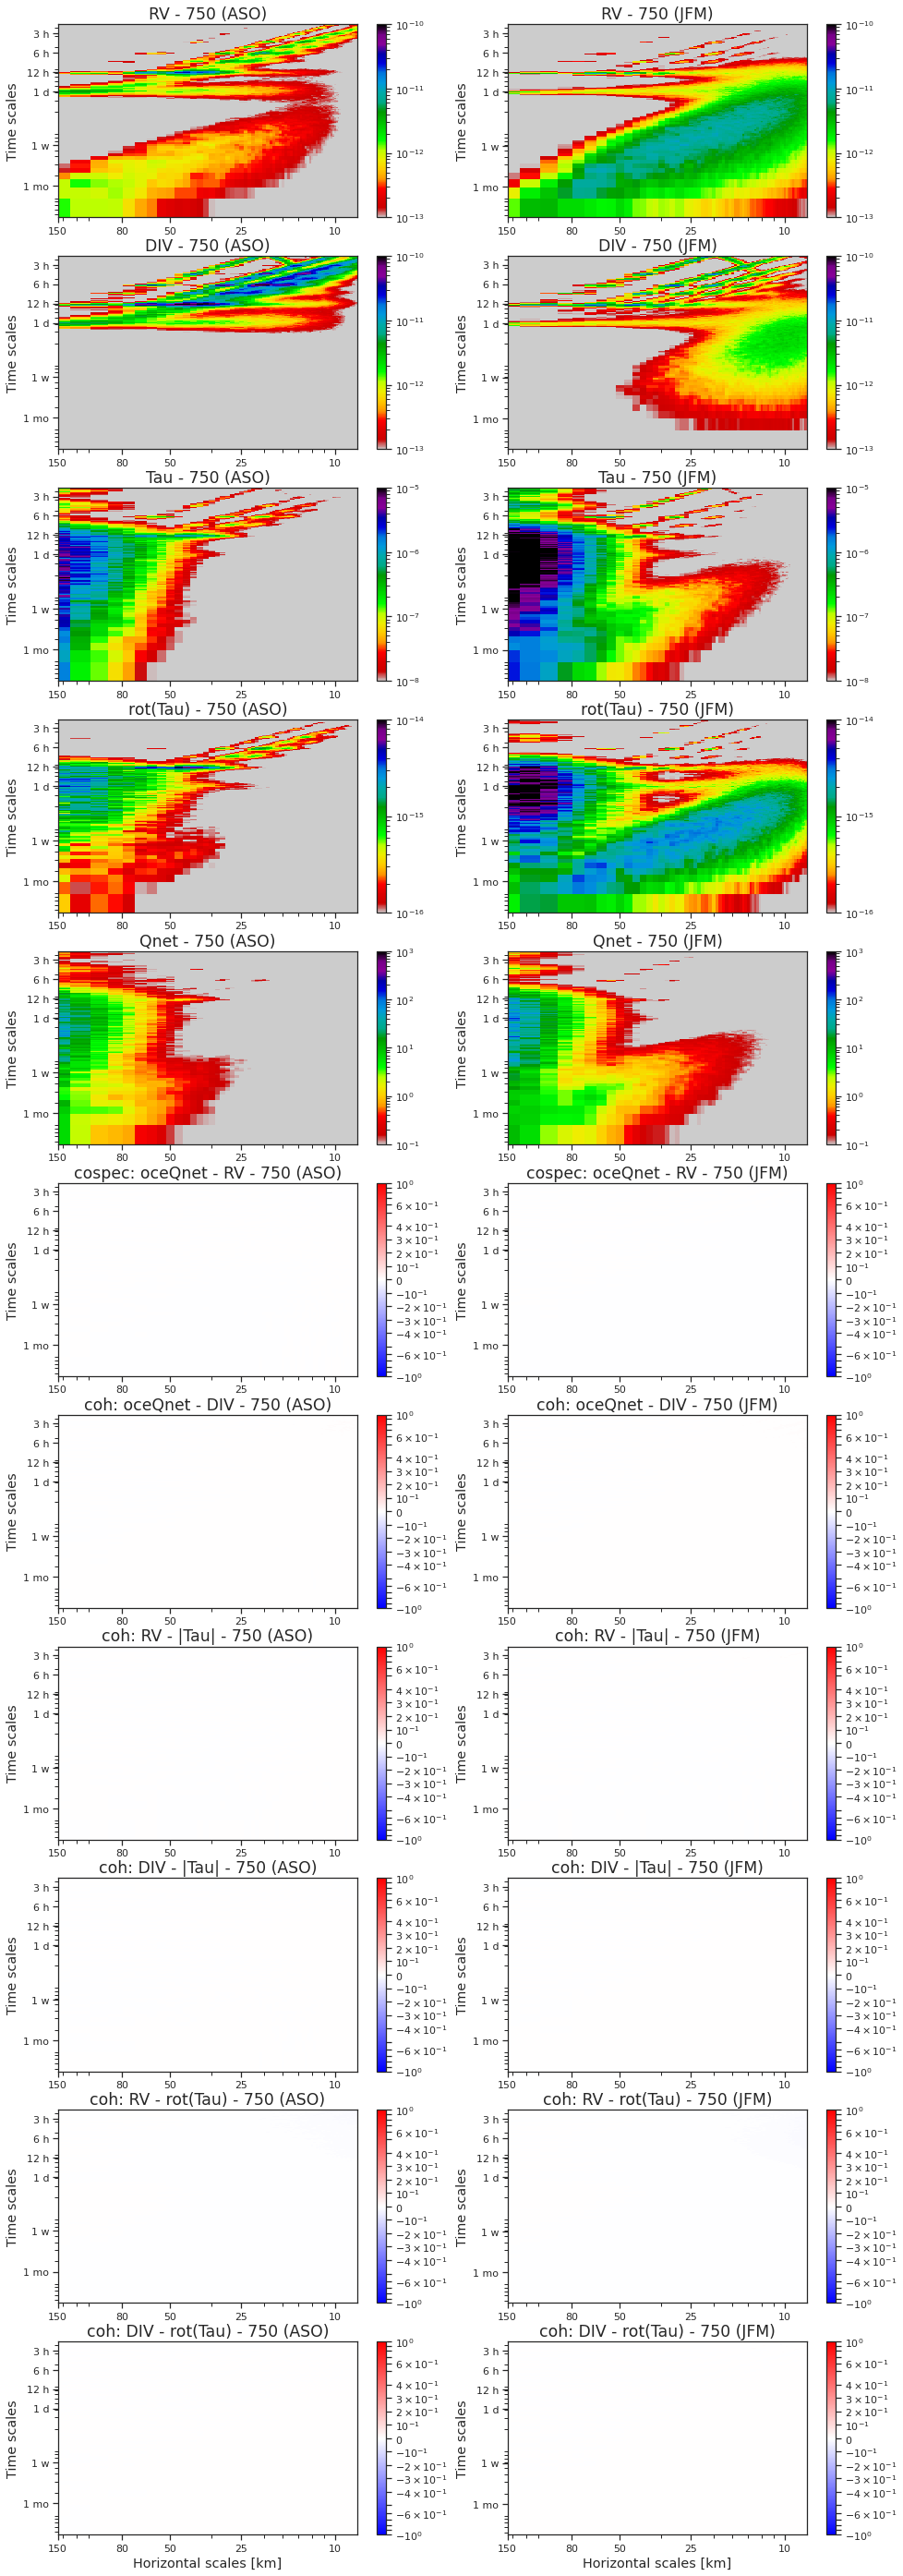

In [12]:
calc_cospectra("Canarias")

2021-03-10 16:37:27 INFO     Plotting: 450 ASO
2021-03-10 16:37:28 INFO     Grid: dx = 1.6332722937931032 km, dy = 1.7626001551724138 km, dt = 1 h
2021-03-10 16:37:28 INFO     Exists? 450: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/450_ASO_hours.npz
2021-03-10 16:37:28 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-03-10 16:37:28 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)
2021-03-10 16:37:58 INFO     Loading U: shape (k=0): (290, 289, 2208)
2021-03-10 16:38:45 INFO     Loading V: shape (k=0): (290, 289, 2208)
2021-03-10 16:39:34 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2021-03-10 16:40:27 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)
2021-03-10 16:41:16 INFO     Calculating tau_norm = |tau|
20

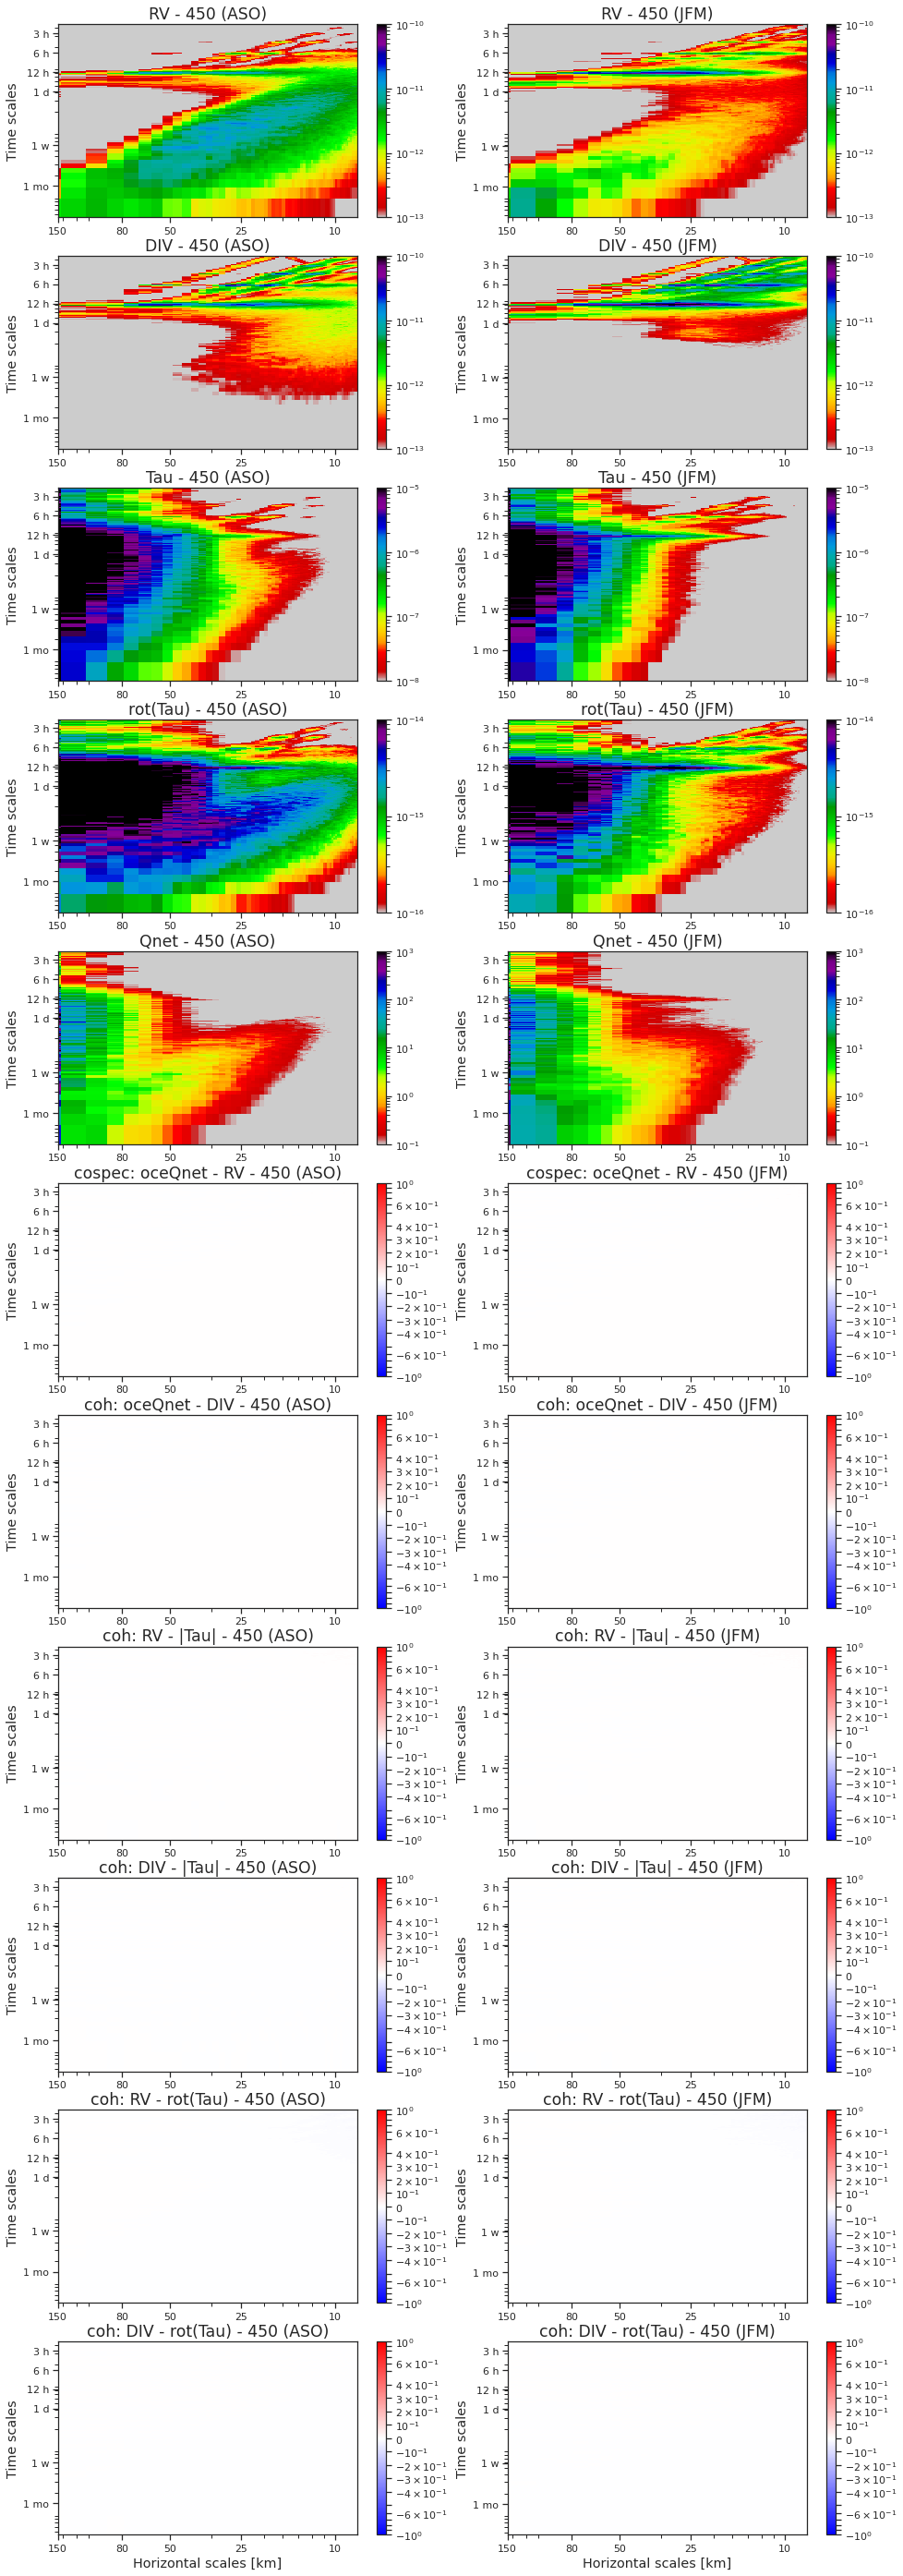

2021-03-10 16:54:47 INFO     Plotting: 572 ASO
2021-03-10 16:54:49 INFO     Grid: dx = 1.9787329799999998 km, dy = 2.152516785862069 km, dt = 1 h
2021-03-10 16:54:49 INFO     Exists? 572: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/572_ASO_hours.npz
2021-03-10 16:54:49 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-03-10 16:54:49 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)
2021-03-10 16:55:23 INFO     Loading U: shape (k=0): (290, 289, 2208)
2021-03-10 16:56:11 INFO     Loading V: shape (k=0): (290, 289, 2208)
2021-03-10 16:56:56 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2021-03-10 16:57:44 INFO     Loading oceTA

In [ ]:
calc_cospectra("Peru")

2021-03-10 17:05:23 INFO     Plotting: 533 ASO
2021-03-10 17:05:24 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902820921527778 km, dt = 1 h
2021-03-10 17:05:24 INFO     Exists? 533: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/533_ASO_hours.npz
2021-03-10 17:05:25 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-03-10 17:05:25 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2021-03-10 17:06:15 INFO     Loading U: shape (k=0): (288, 289, 2208)
2021-03-10 17:07:00 INFO     Loading V: shape (k=0): (288, 289, 2208)
2021-03-10 17:07:45 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2021-03-10 17:08:31 INFO     Loading oceTA

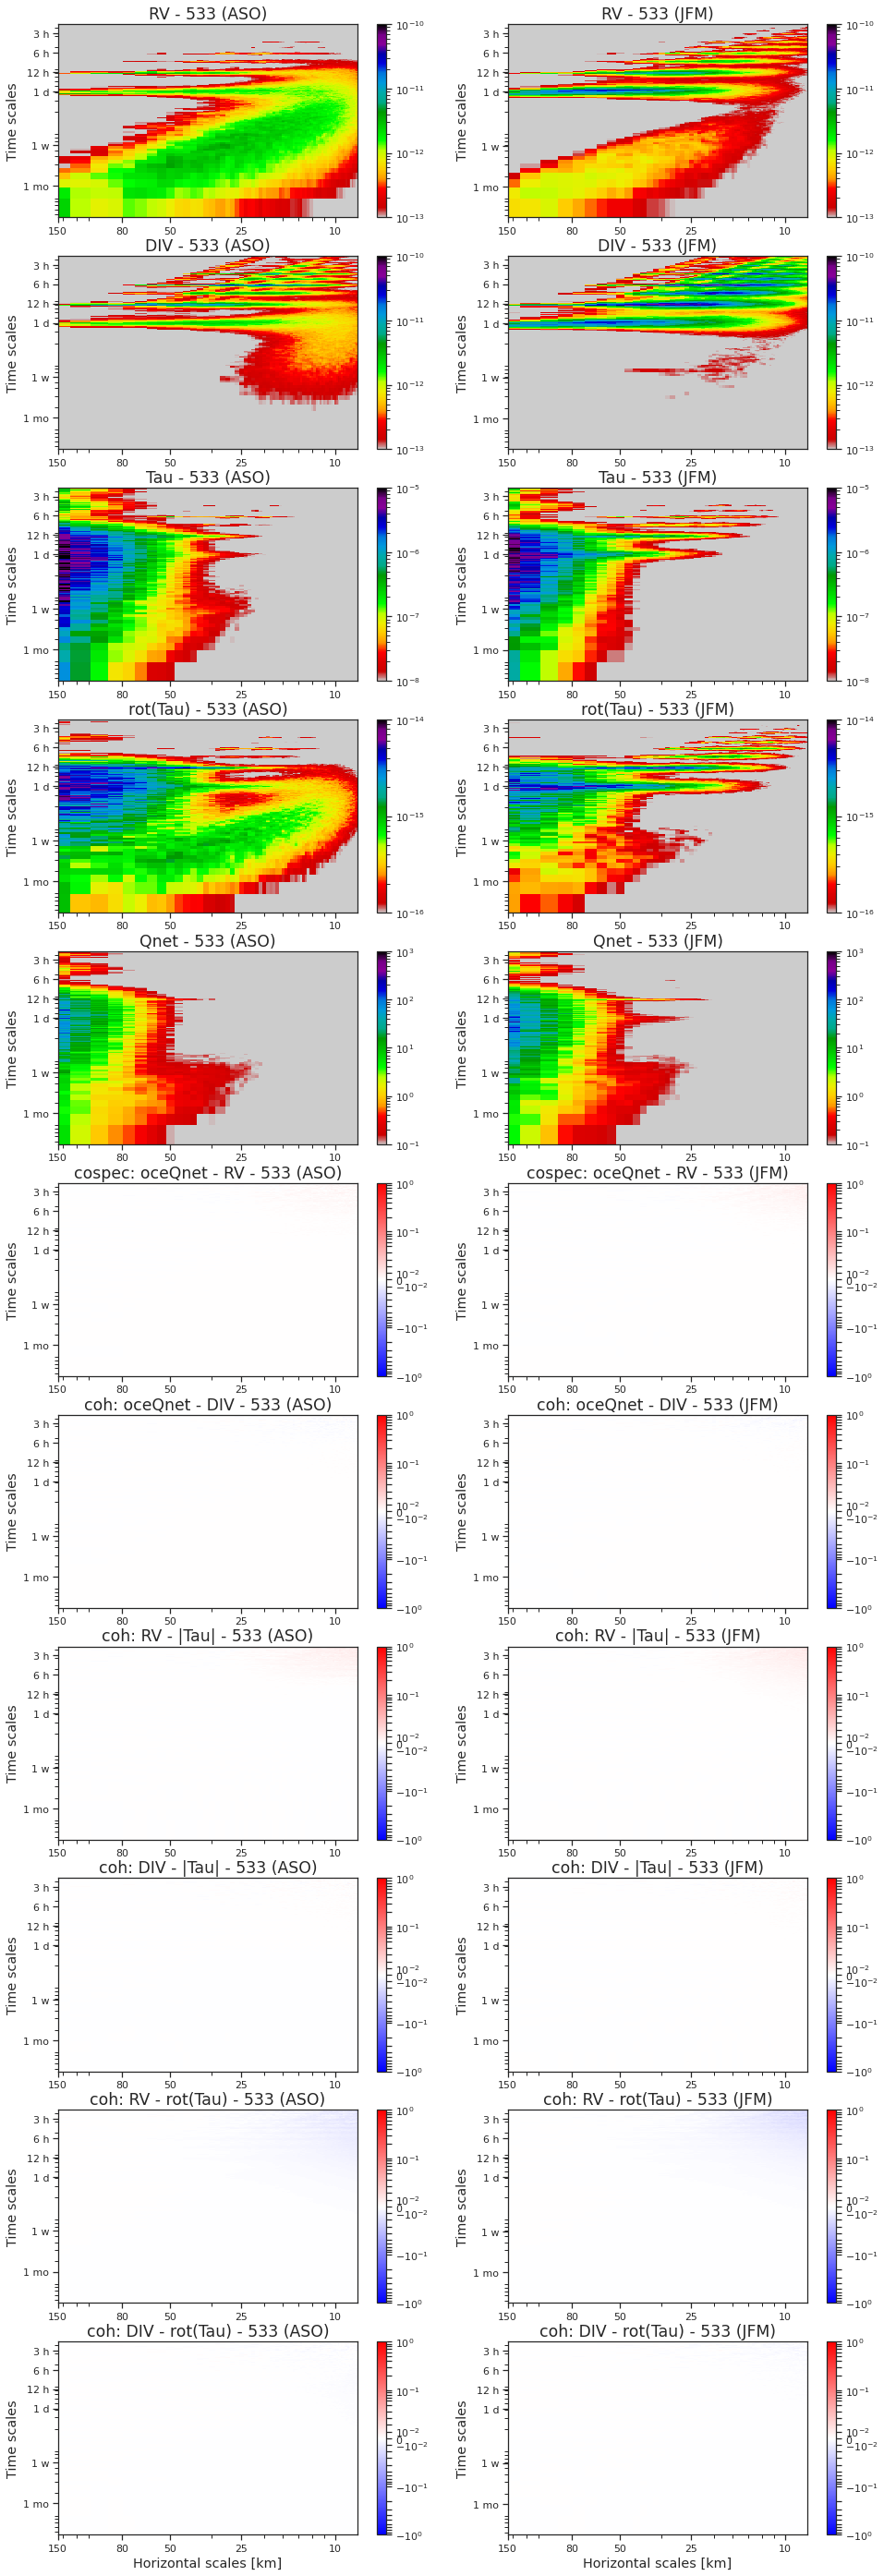

In [13]:
calc_cospectra("Benguela")

Plotting: 762 ASO


2021-02-04 11:11:05 INFO     Grid: dx = 1.9028209215277783 km, dy = 2.0694956027777773 km, dt = 1 h
2021-02-04 11:11:05 INFO     Exists? 762: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/762_ASO_hours.npz
2021-02-04 11:11:05 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec', 'Qnet_RV_coh', 'Qnet_DIV_coh', 'Tau_RV_coh', 'Tau_DIV_coh', 'rotTau_RV_coh', 'rotTau_DIV_coh']
2021-02-04 11:11:05 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2021-02-04 11:11:10 INFO     Loading U: shape (k=0): (288, 289, 2208)
2021-02-04 11:11:15 INFO     Loading V: shape (k=0): (288, 289, 2208)
2021-02-04 11:11:21 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2021-02-04 11:11:27 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)
2021-02-04 1

float() argument must be a string or a number, not 'list'
Plotting: 750 ASO


2021-02-04 11:15:33 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2021-02-04 11:15:33 INFO     Exists? 750: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/750_ASO_hours.npz
2021-02-04 11:15:33 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-02-04 11:15:33 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2021-02-04 11:15:38 INFO     Loading U: shape (k=0): (288, 289, 2208)
2021-02-04 11:15:44 INFO     Loading V: shape (k=0): (288, 289, 2208)
2021-02-04 11:15:50 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2021-02-04 11:15:55 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)
2021-02-04 11:16:00 INFO     Calculating tau_norm = |tau|
2021-02-04 11:16:02 INFO     Calculating tau_curl 

float() argument must be a string or a number, not 'list'
Plotting: 572 ASO


2021-02-04 11:19:47 INFO     Grid: dx = 1.9787329799999998 km, dy = 2.152516785862069 km, dt = 1 h
2021-02-04 11:19:47 INFO     Exists? 572: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/572_ASO_hours.npz
2021-02-04 11:19:47 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-02-04 11:19:47 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)
2021-02-04 11:20:14 INFO     Loading U: shape (k=0): (290, 289, 2208)
2021-02-04 11:20:49 INFO     Loading V: shape (k=0): (290, 289, 2208)
2021-02-04 11:21:25 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2021-02-04 11:22:02 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)
2021-02-04 11:22:39 INFO     Calculating tau_norm = |tau|
2021-02-04 11:22:41 INFO     Calculating tau_curl 

float() argument must be a string or a number, not 'list'
Plotting: 533 ASO


2021-02-04 11:27:00 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902820921527778 km, dt = 1 h
2021-02-04 11:27:00 INFO     Exists? 533: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/533_ASO_hours.npz
2021-02-04 11:27:00 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-02-04 11:27:00 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2021-02-04 11:27:38 INFO     Loading U: shape (k=0): (288, 289, 2208)
2021-02-04 11:28:13 INFO     Loading V: shape (k=0): (288, 289, 2208)
2021-02-04 11:28:48 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2021-02-04 11:29:23 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)
2021-02-04 11:29:59 INFO     Calculating tau_norm = |tau|
2021-02-04 11:30:01 INFO     Calculating tau_curl 

float() argument must be a string or a number, not 'list'


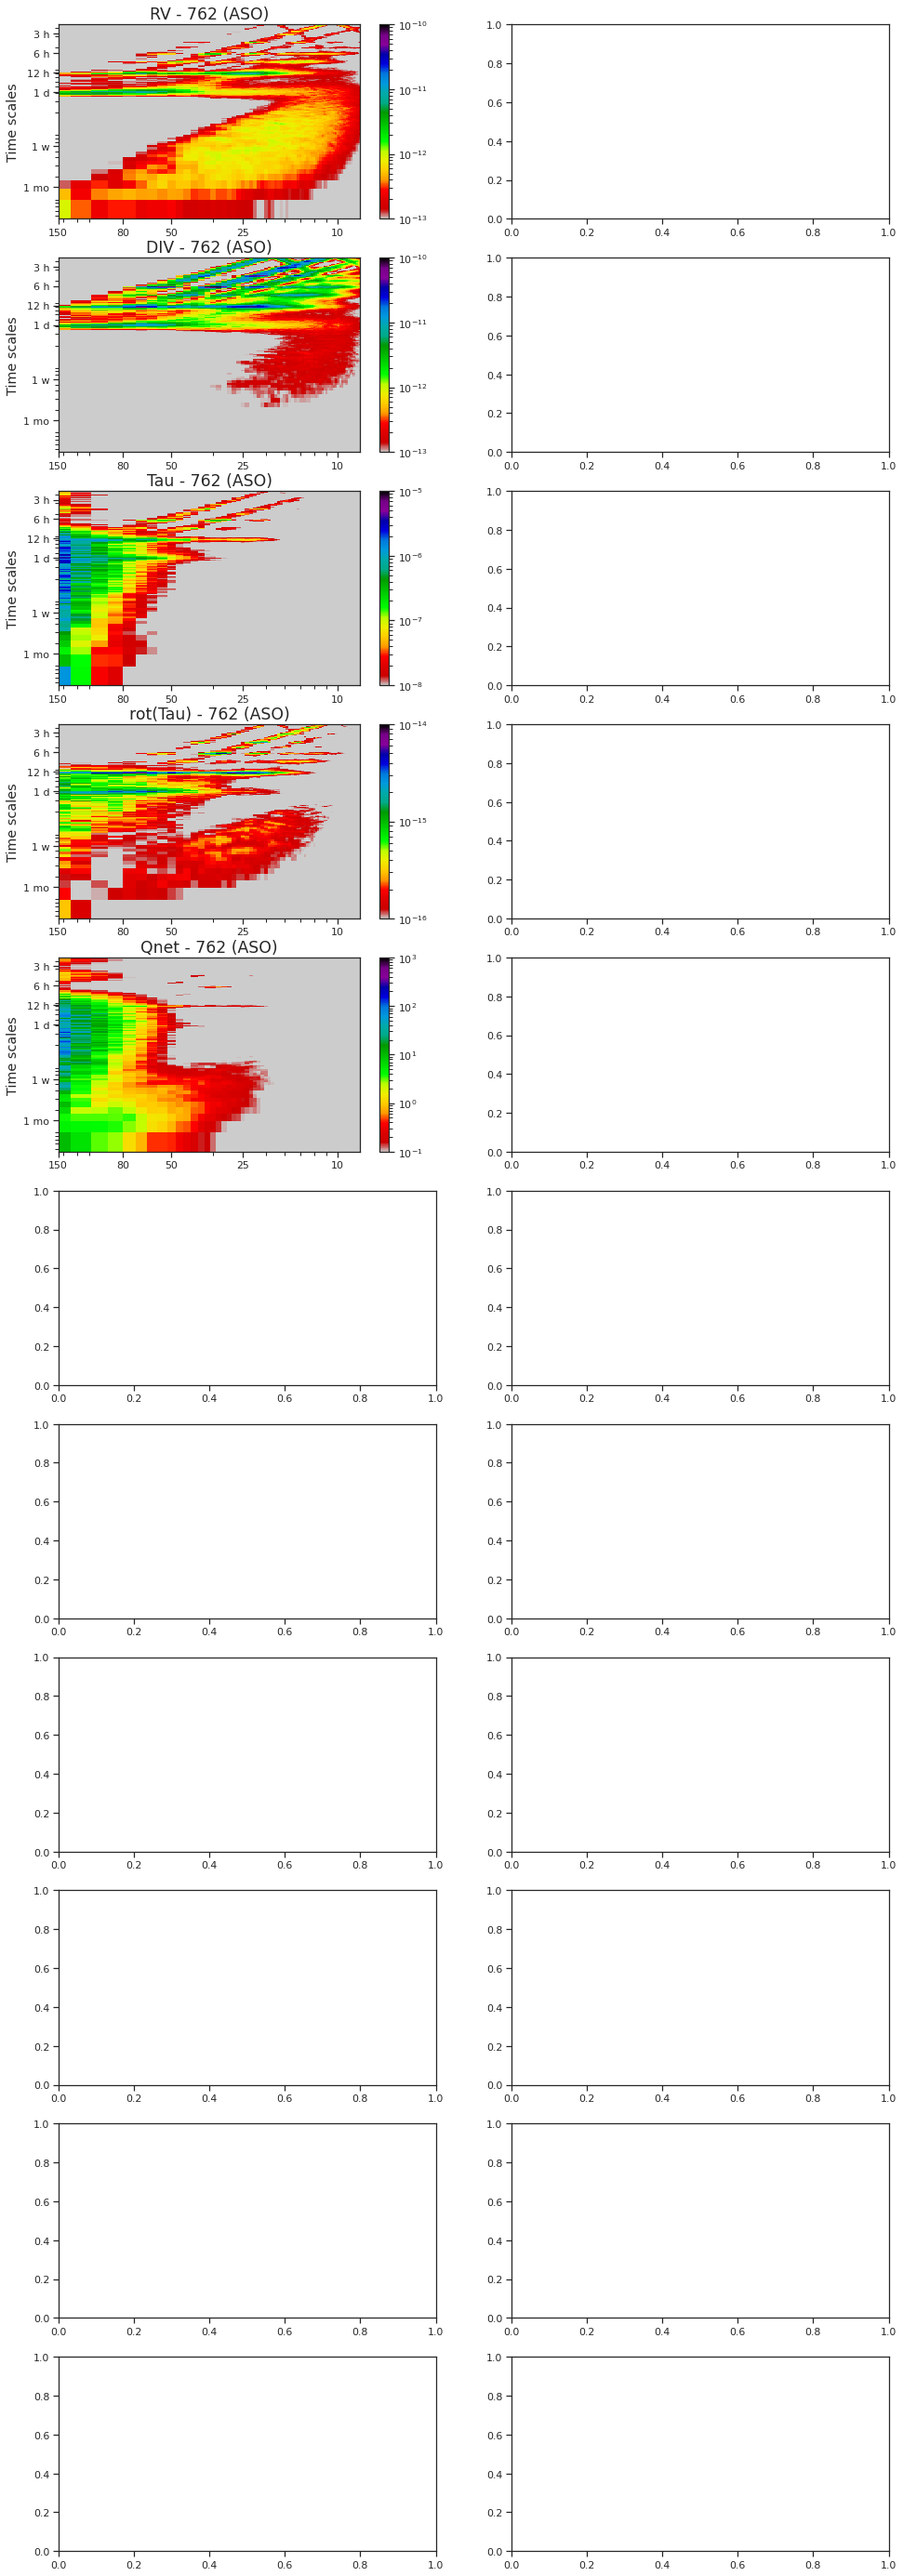

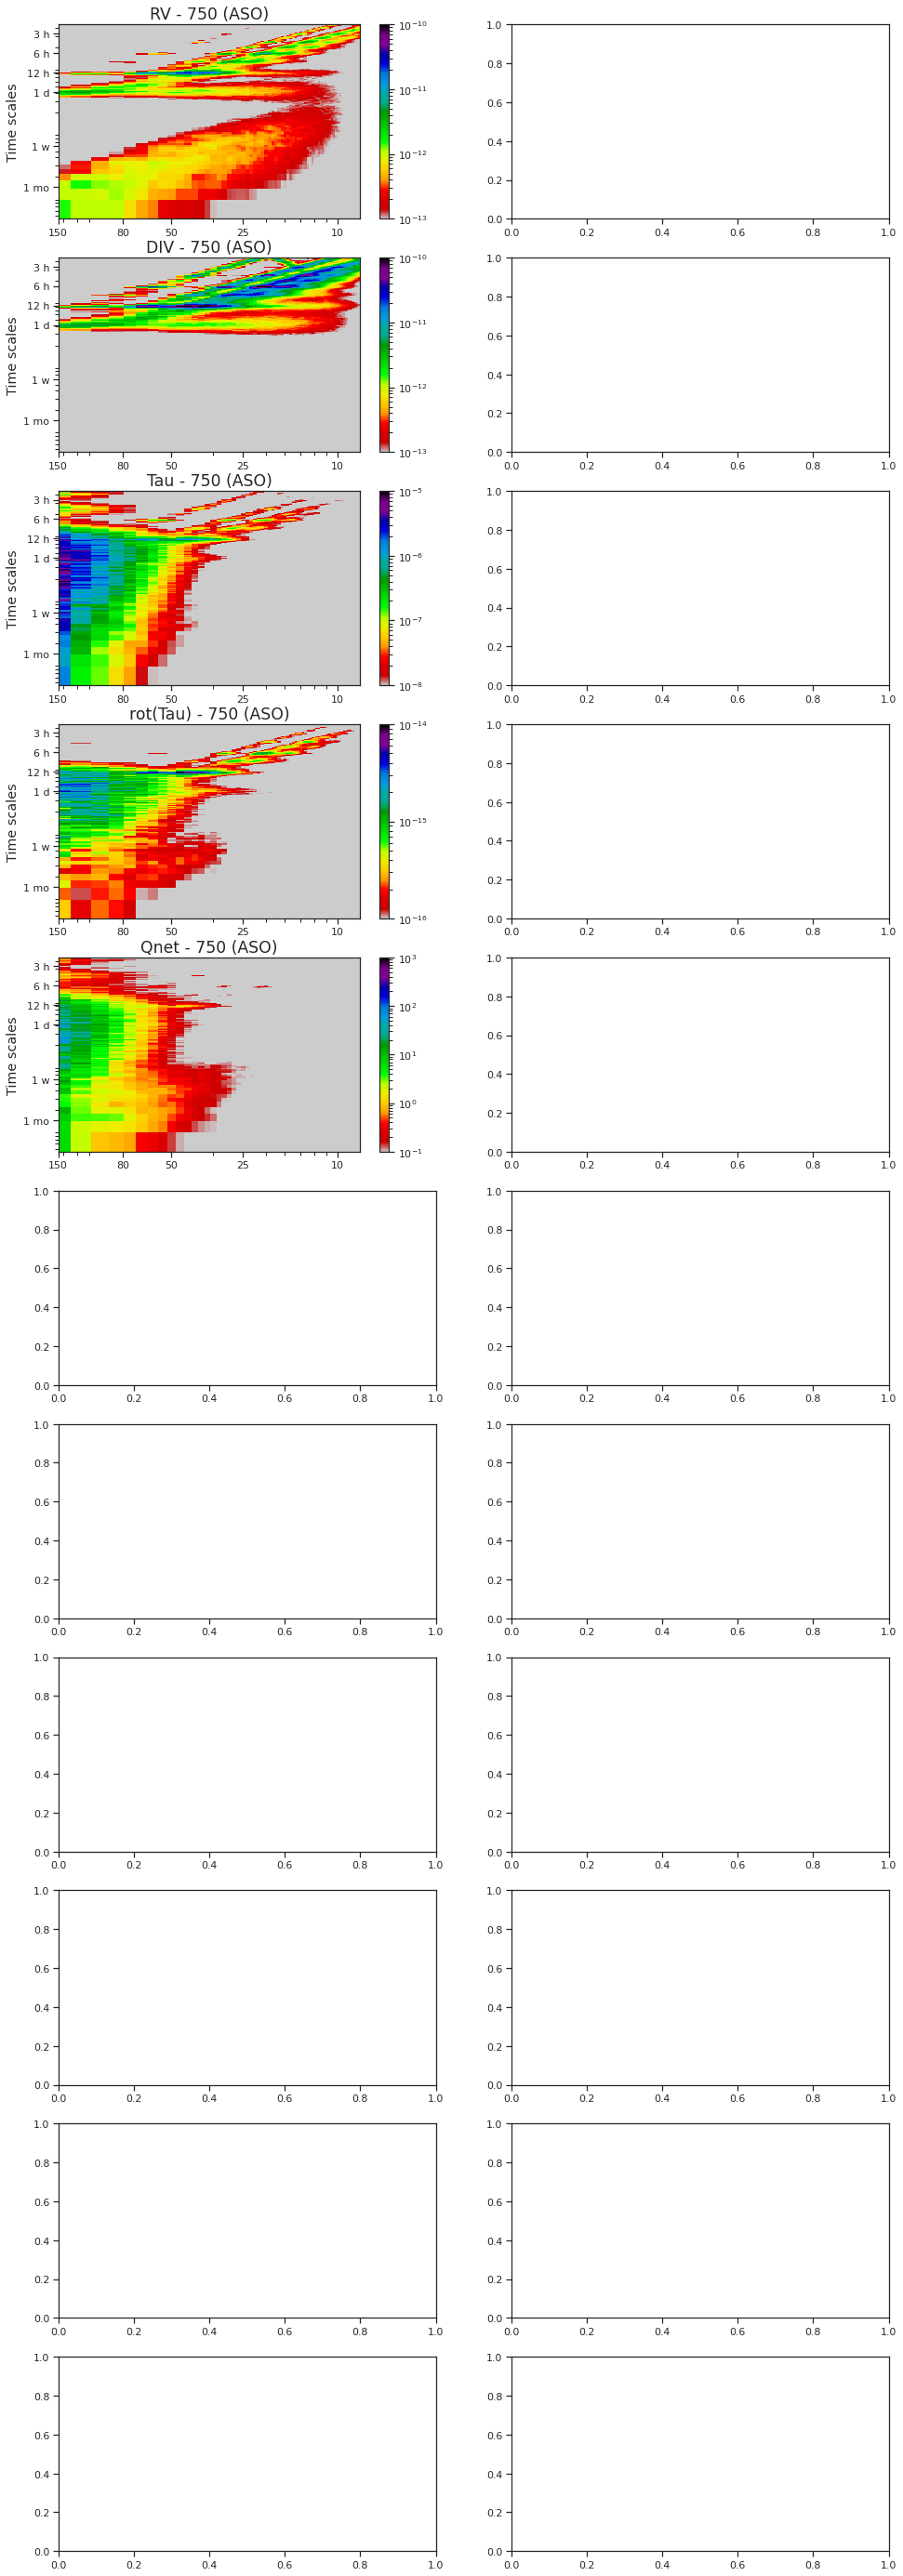

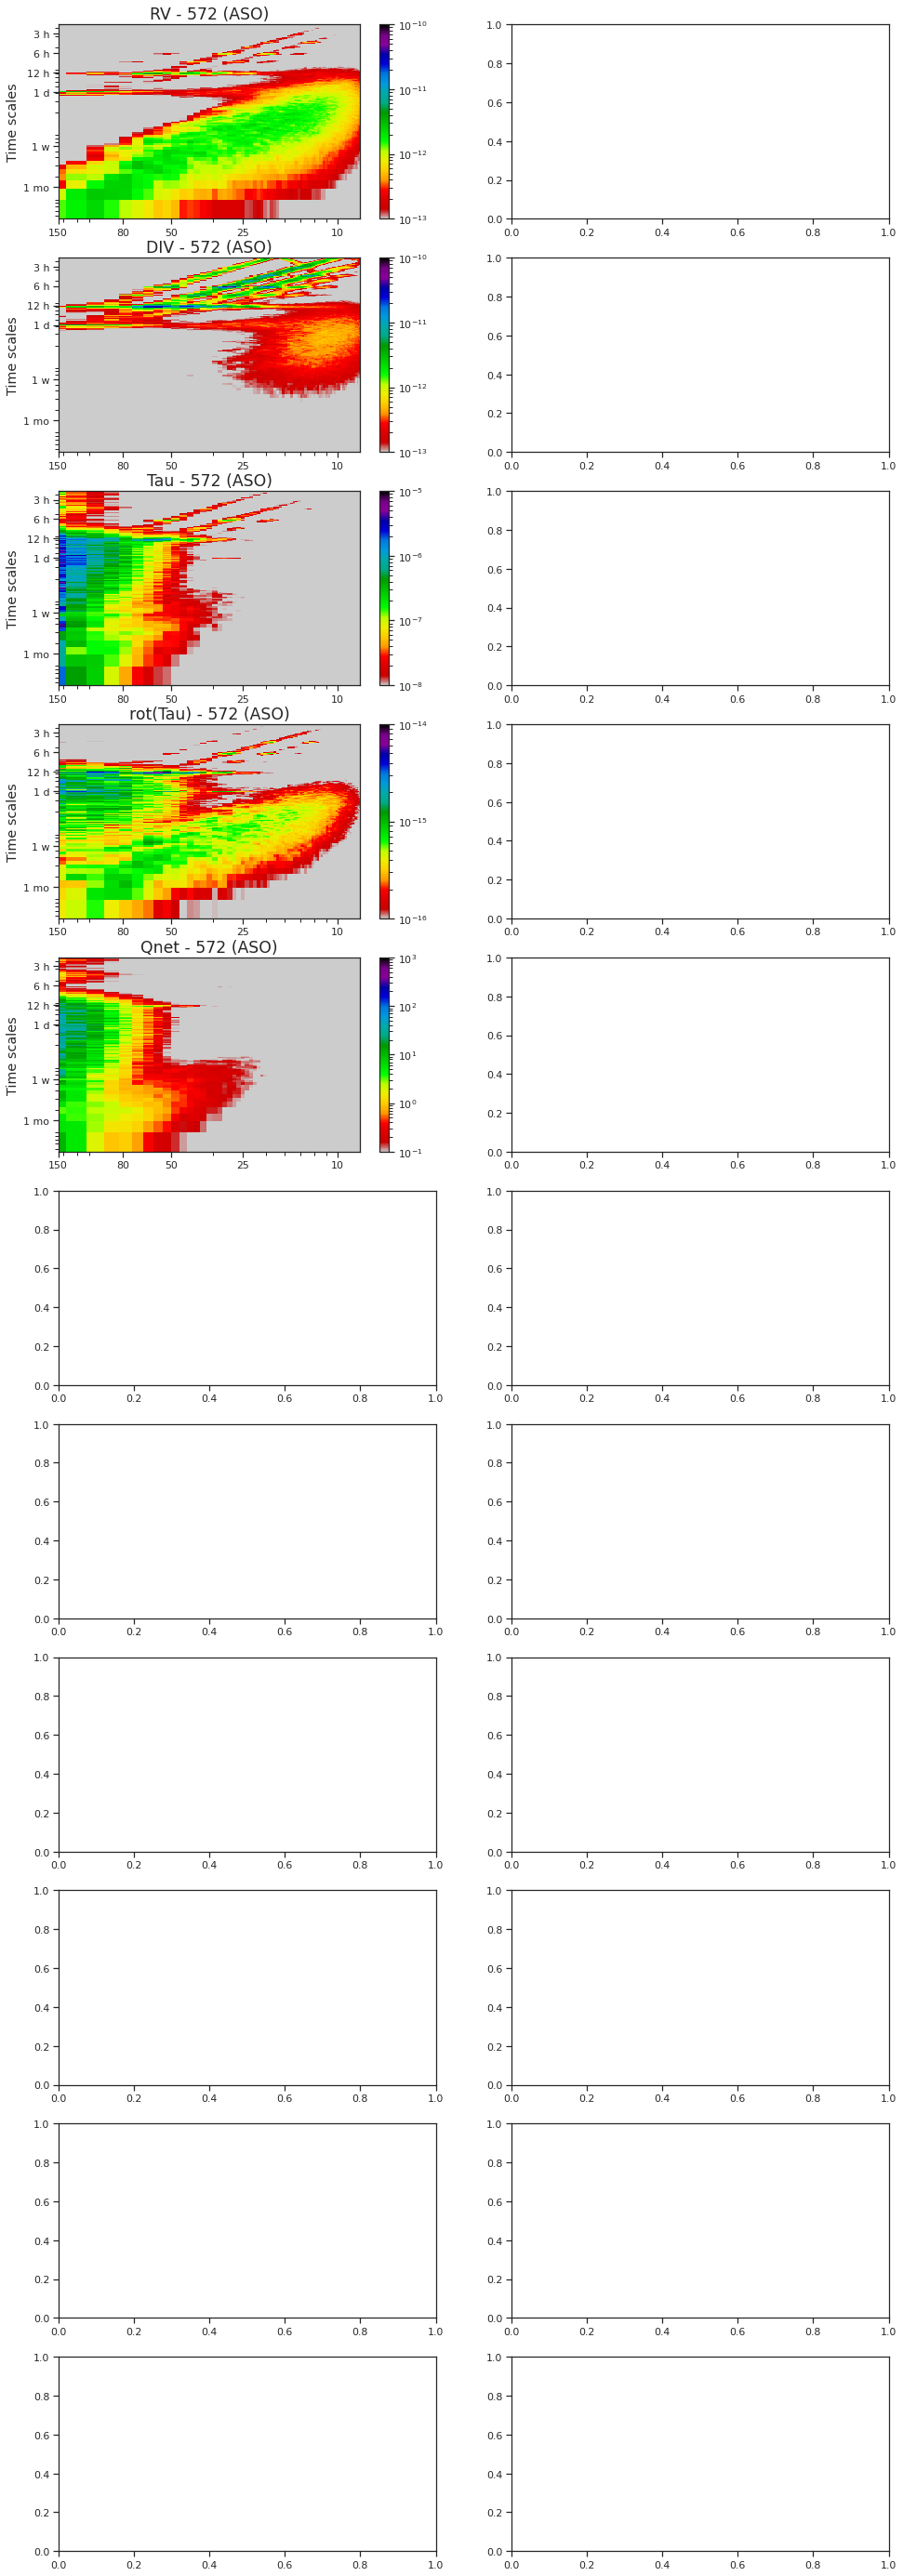

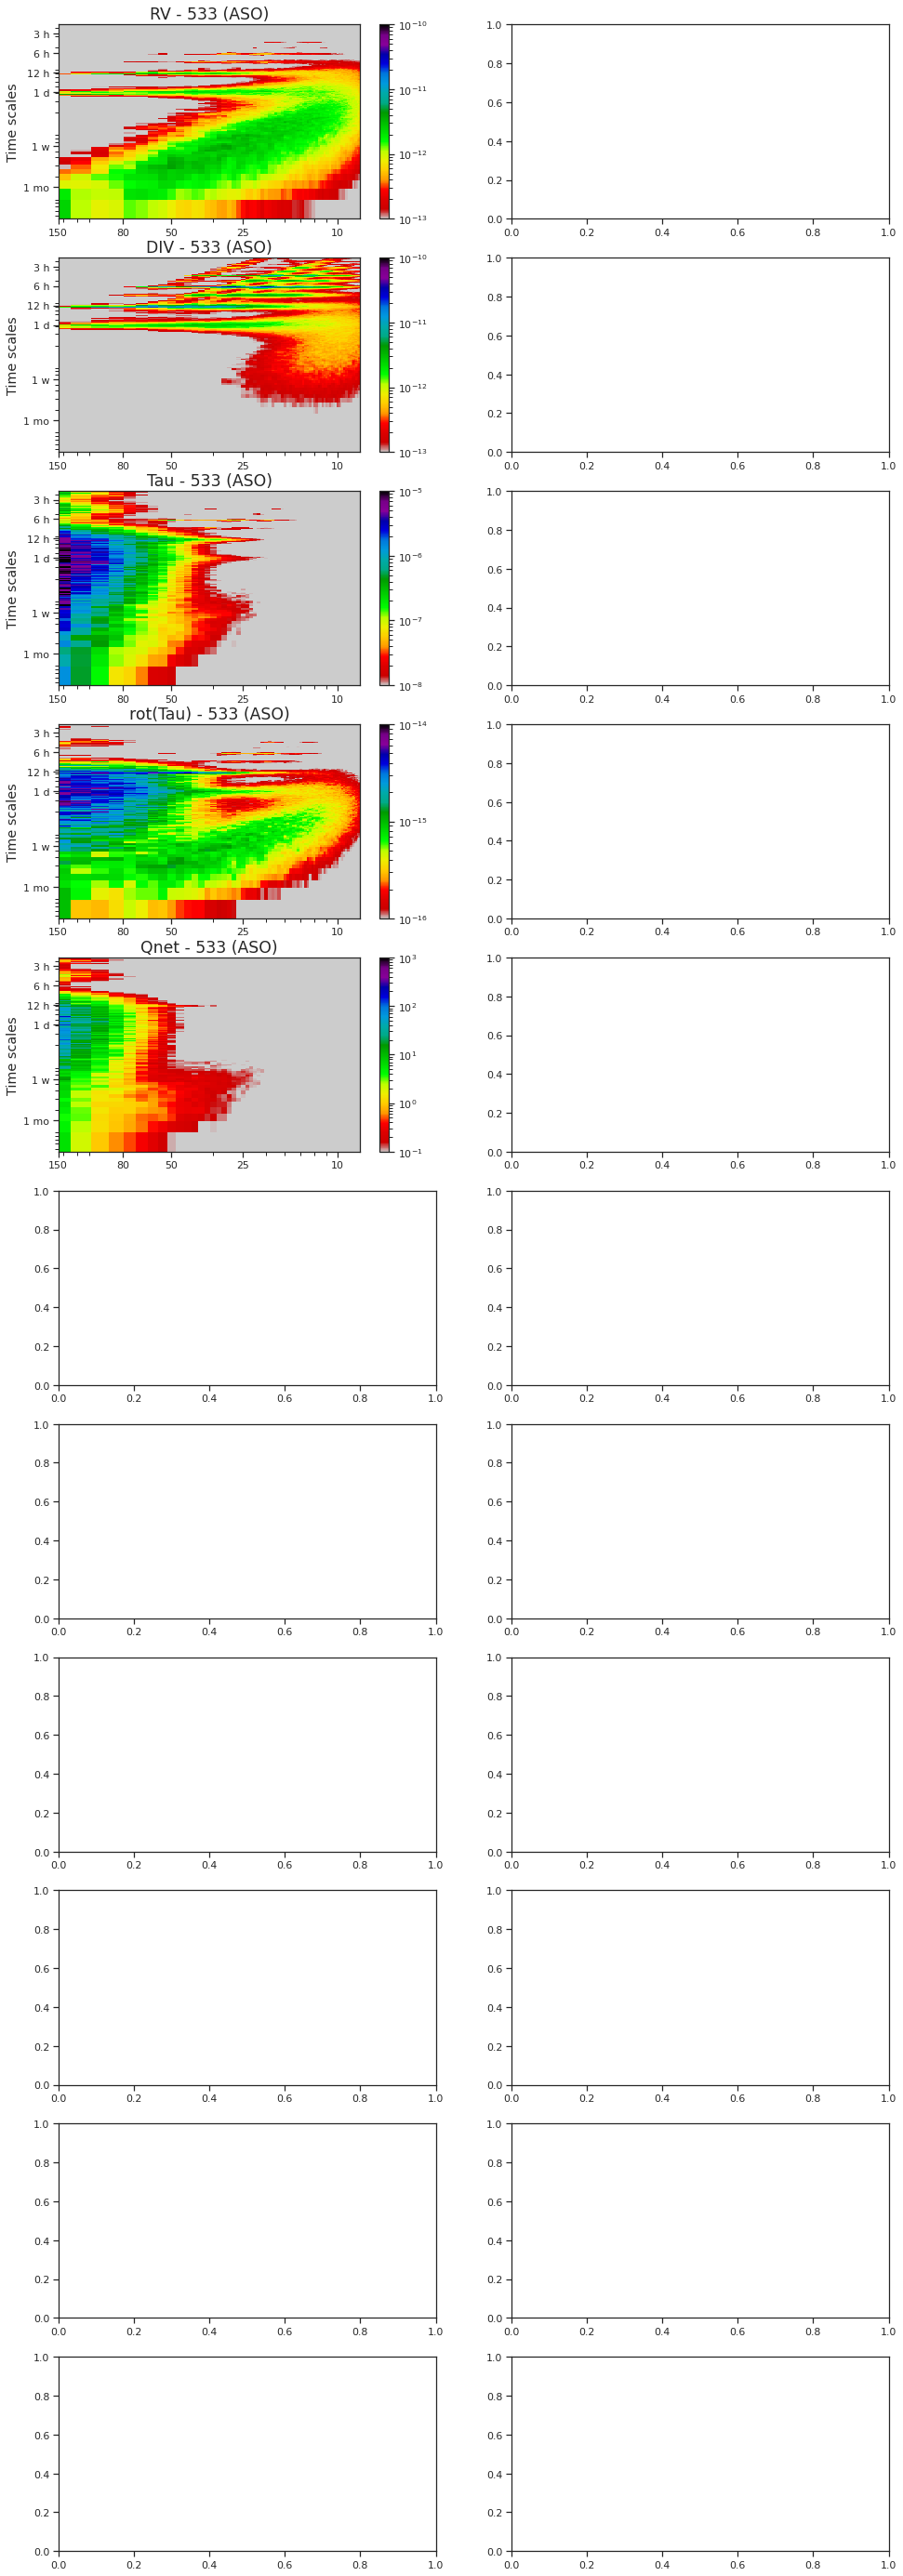

In [16]:
for rid in [762, 750, 572, 533]:
    try:
        plotRegion(rid)
    except Exception as err:
        print(err)

Plotting: 762 ASO


2021-01-28 19:44:13 INFO     Grid: dx = 1.9028209215277783 km, dy = 2.0694956027777773 km, dt = 1 h
2021-01-28 19:44:13 INFO     Exists? 762: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/762_ASO_hours.npz
2021-01-28 19:44:14 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-01-28 19:44:14 INFO     All spectra - dict_keys(['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec'])
2021-01-28 19:44:15 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/762_ASO_hours.npz: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k

Plotting: 762 JFM


2021-01-28 19:44:16 INFO     Grid: dx = 1.9028209215277783 km, dy = 2.0694956027777773 km, dt = 1 h
2021-01-28 19:44:16 INFO     Exists? 762: _JFM -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/762_JFM_hours.npz
2021-01-28 19:44:17 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-01-28 19:44:17 INFO     All spectra - dict_keys(['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec'])
2021-01-28 19:44:18 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/762_JFM_hours.npz: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k

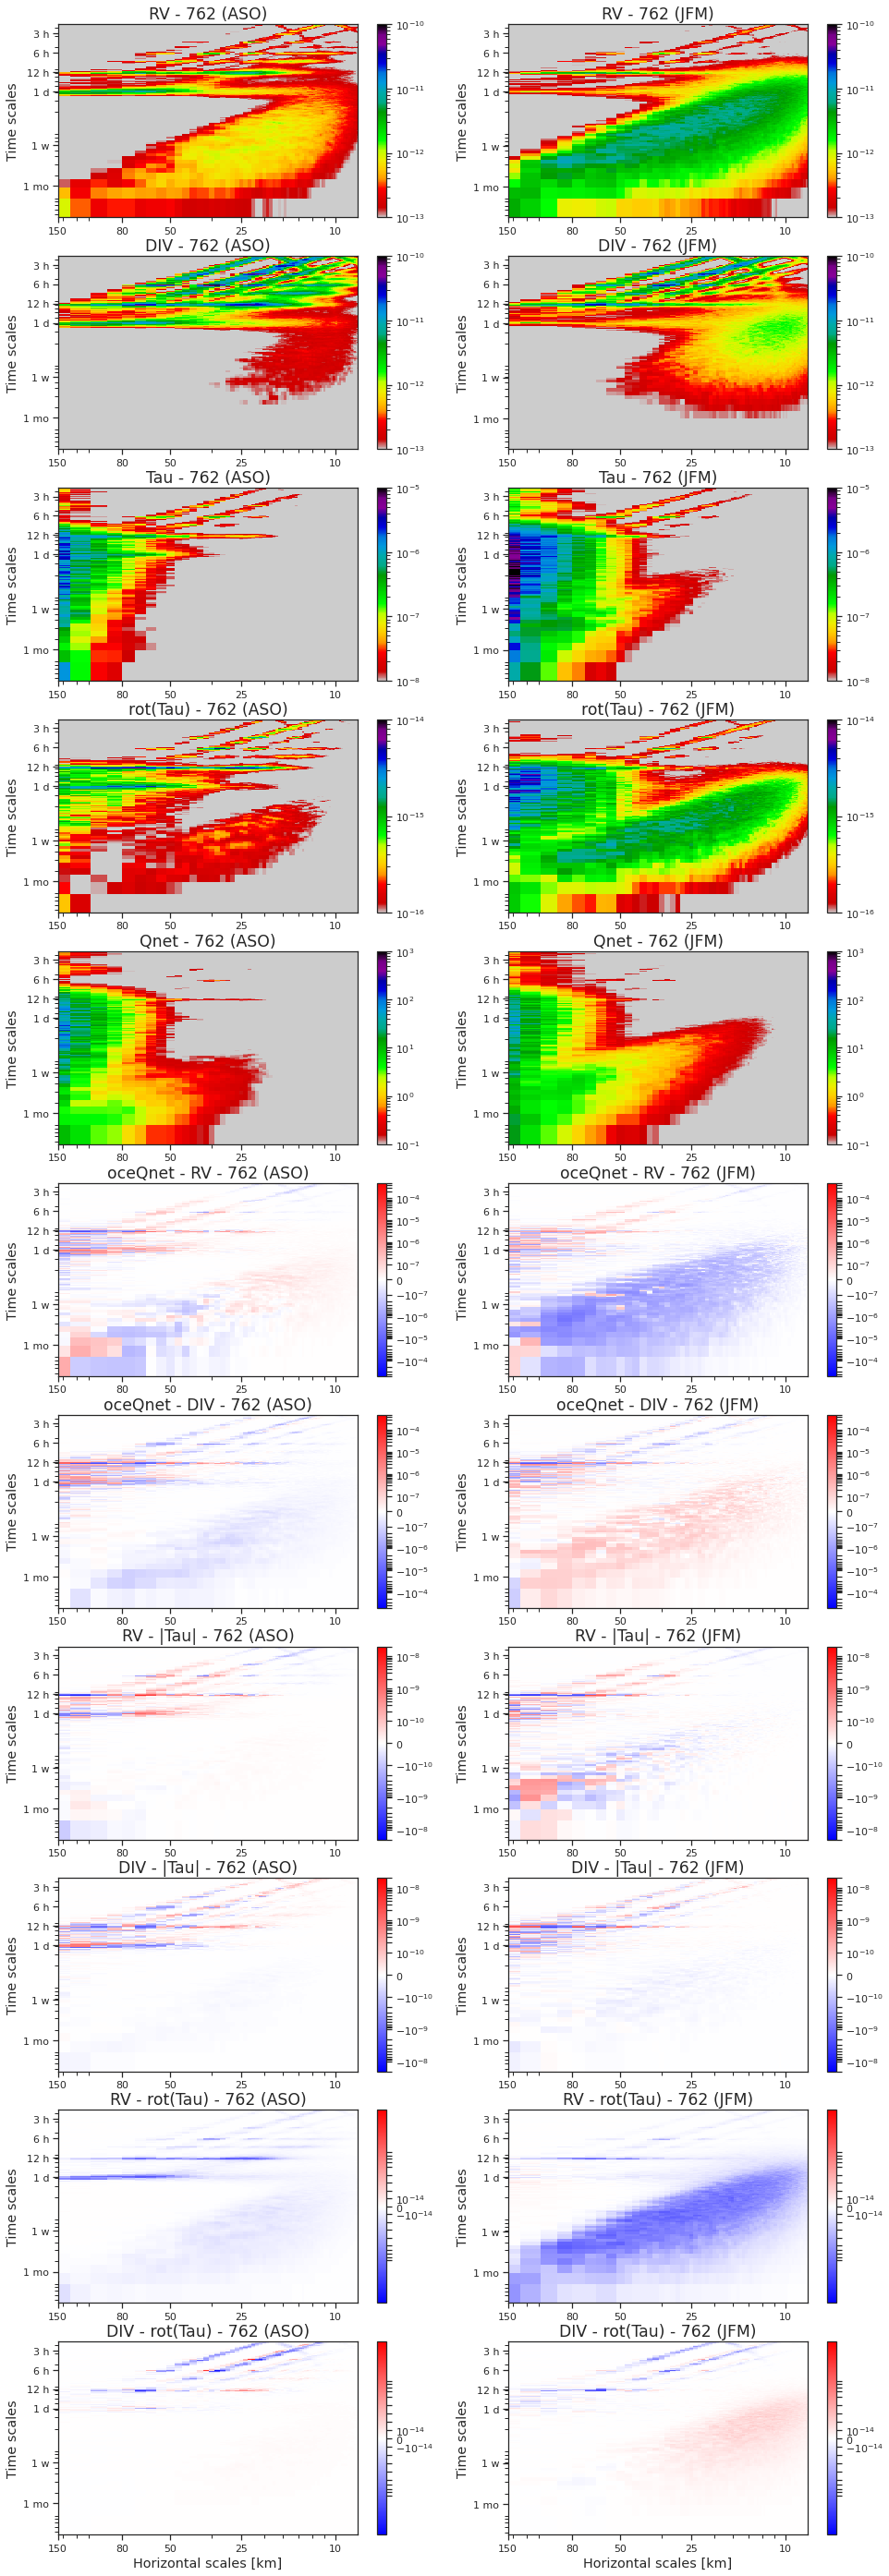

Plotting: 868 ASO


2021-01-28 19:44:31 INFO     Grid: dx = 1.4436056939434434 km, dy = 1.5374227972413794 km, dt = 1 h
2021-01-28 19:44:31 INFO     Exists? 868: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/868_ASO_hours.npz


Error -3 while decompressing data: invalid distance too far back
Plotting: 750 ASO


2021-01-28 19:44:33 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2021-01-28 19:44:33 INFO     Exists? 750: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/750_ASO_hours.npz
2021-01-28 19:44:34 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-01-28 19:44:34 INFO     All spectra - dict_keys(['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec'])
2021-01-28 19:44:35 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/750_ASO_hours.npz: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k'

Plotting: 750 JFM


2021-01-28 19:44:37 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2021-01-28 19:44:37 INFO     Exists? 750: _JFM -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/750_JFM_hours.npz
2021-01-28 19:44:37 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-01-28 19:44:37 INFO     All spectra - dict_keys(['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec'])
2021-01-28 19:44:38 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/750_JFM_hours.npz: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k'

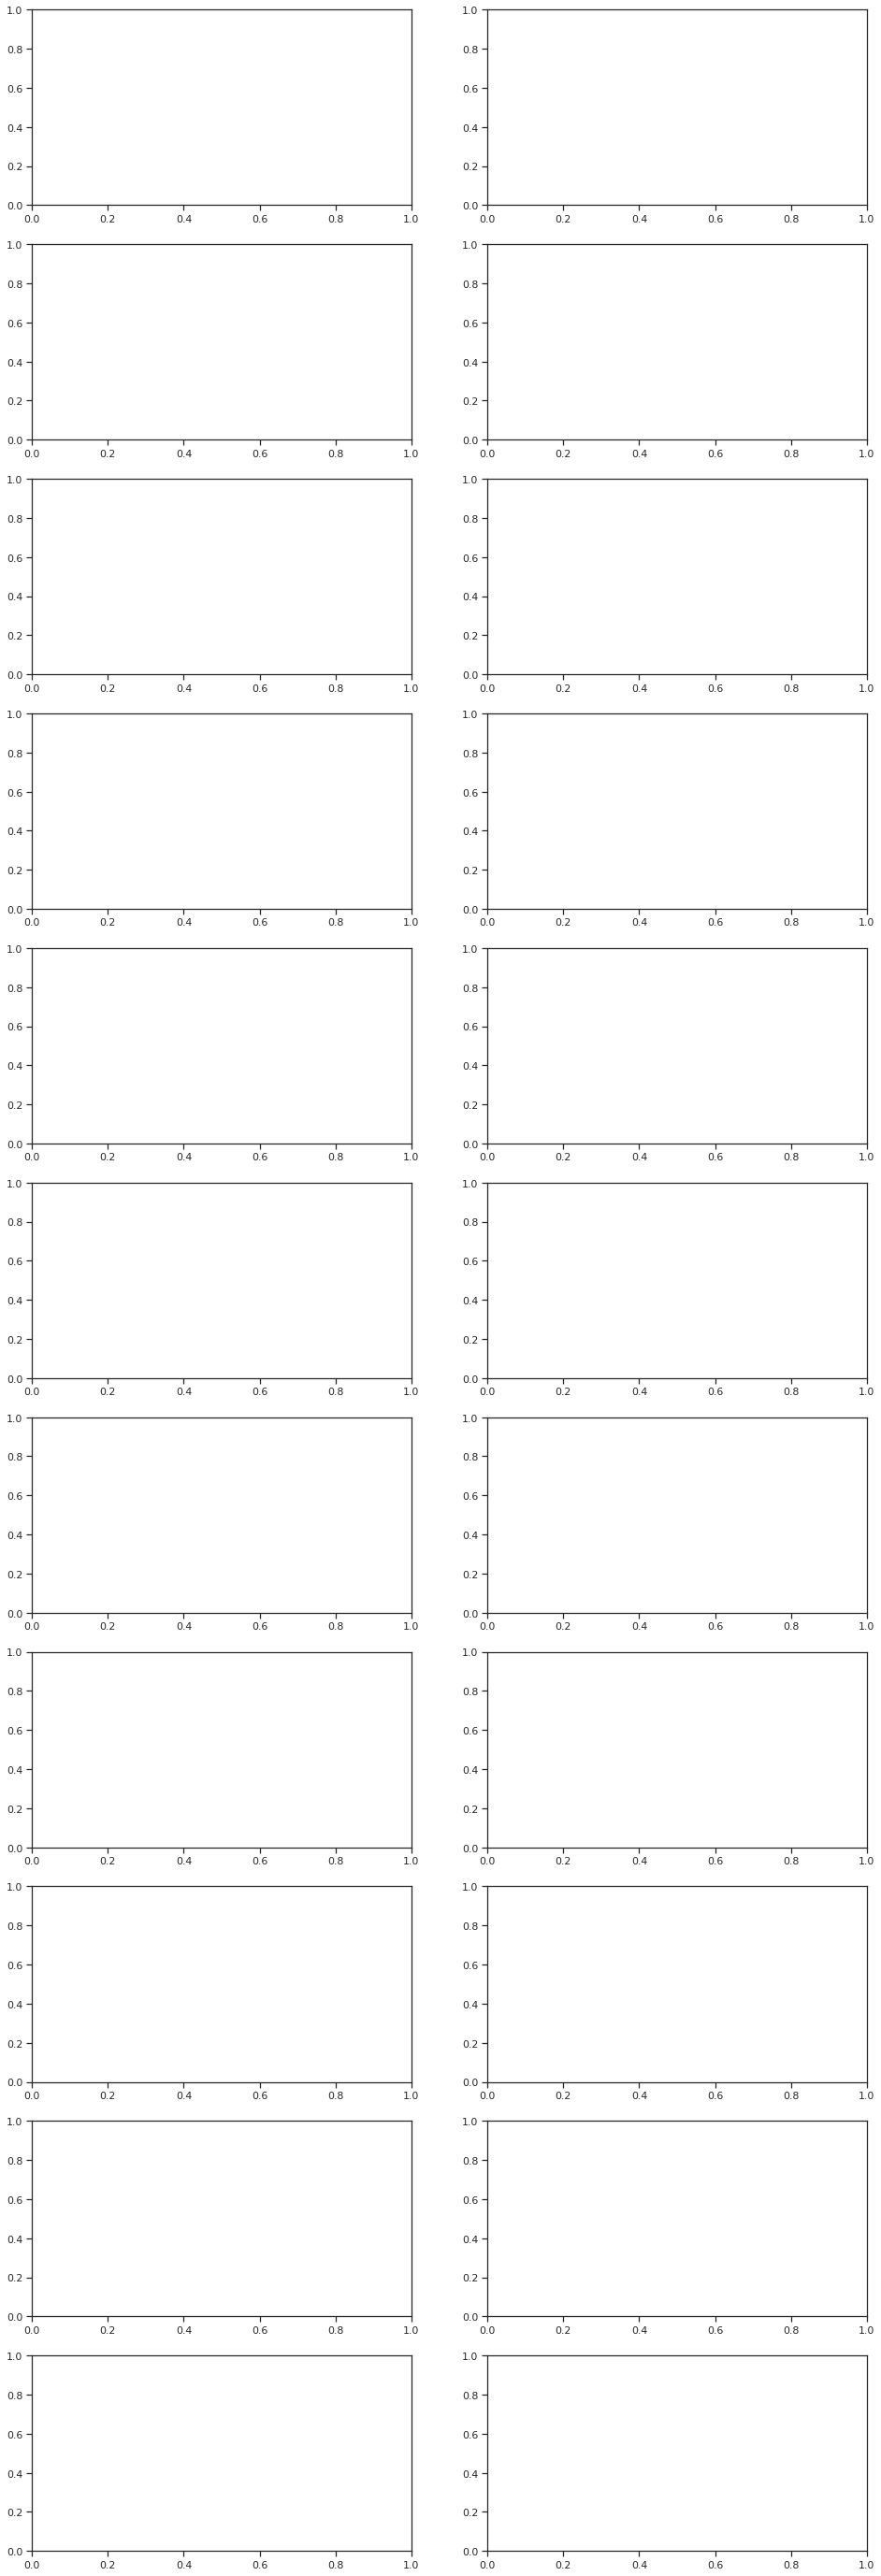

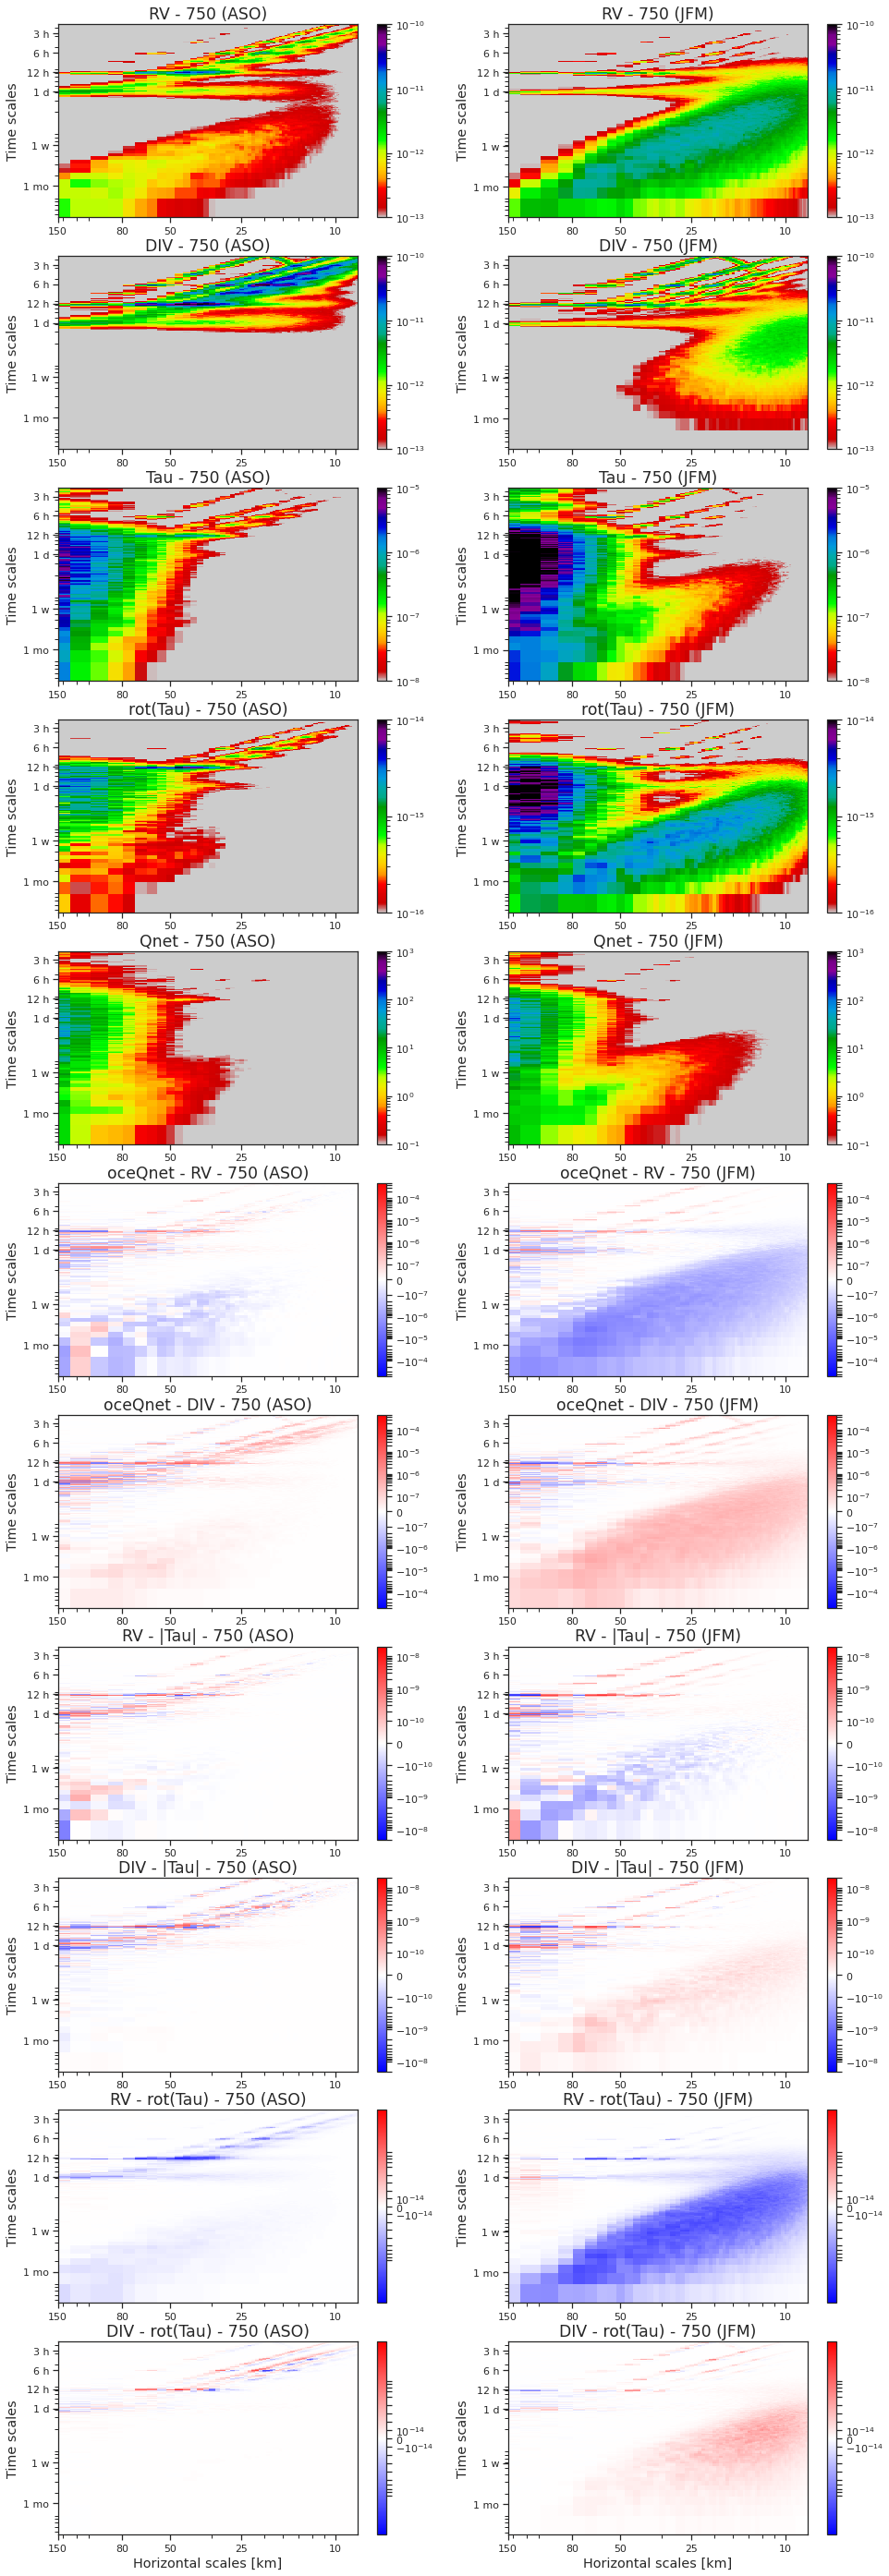

Plotting: 450 ASO


2021-01-28 19:44:54 INFO     Grid: dx = 1.6332722937931032 km, dy = 1.7626001551724138 km, dt = 1 h
2021-01-28 19:44:54 INFO     Exists? 450: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/450_ASO_hours.npz
2021-01-28 19:44:54 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-01-28 19:44:54 INFO     All spectra - dict_keys(['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec'])
2021-01-28 19:44:56 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/450_ASO_hours.npz: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k

Plotting: 450 JFM


2021-01-28 19:44:57 INFO     Grid: dx = 1.6332722937931032 km, dy = 1.7626001551724138 km, dt = 1 h
2021-01-28 19:44:57 INFO     Exists? 450: _JFM -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/450_JFM_hours.npz
2021-01-28 19:44:57 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-01-28 19:44:57 INFO     All spectra - dict_keys(['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec'])
2021-01-28 19:44:59 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/450_JFM_hours.npz: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k

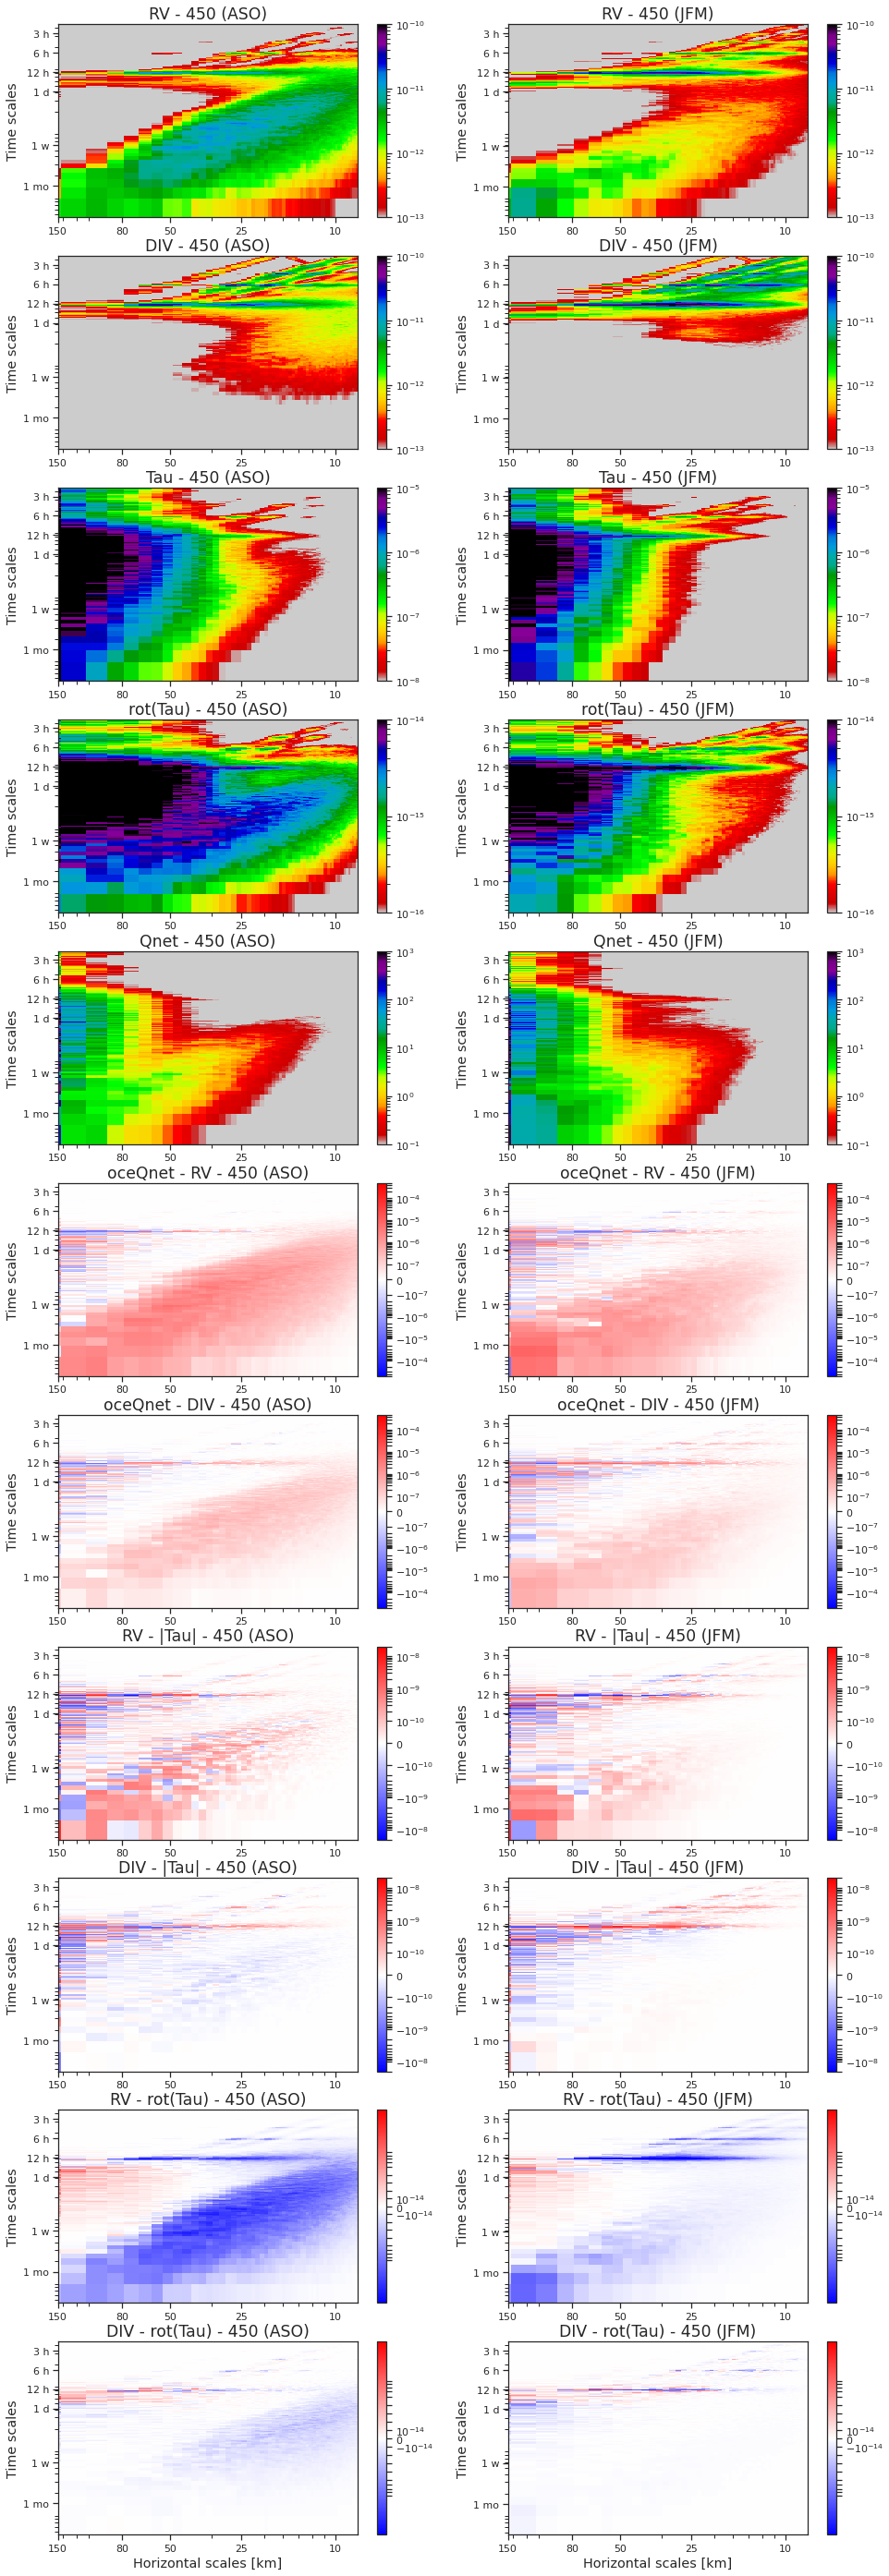

Plotting: 572 ASO


2021-01-28 19:45:13 INFO     Grid: dx = 1.9787329799999998 km, dy = 2.152516785862069 km, dt = 1 h
2021-01-28 19:45:13 INFO     Exists? 572: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/572_ASO_hours.npz
2021-01-28 19:45:14 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-01-28 19:45:14 INFO     All spectra - dict_keys(['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec'])
2021-01-28 19:45:15 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/572_ASO_hours.npz: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k'

Plotting: 572 JFM


2021-01-28 19:45:16 INFO     Grid: dx = 1.9787329799999998 km, dy = 2.152516785862069 km, dt = 1 h
2021-01-28 19:45:16 INFO     Exists? 572: _JFM -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/572_JFM_hours.npz
2021-01-28 19:45:17 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-01-28 19:45:17 INFO     All spectra - dict_keys(['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec'])
2021-01-28 19:45:18 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/572_JFM_hours.npz: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k'

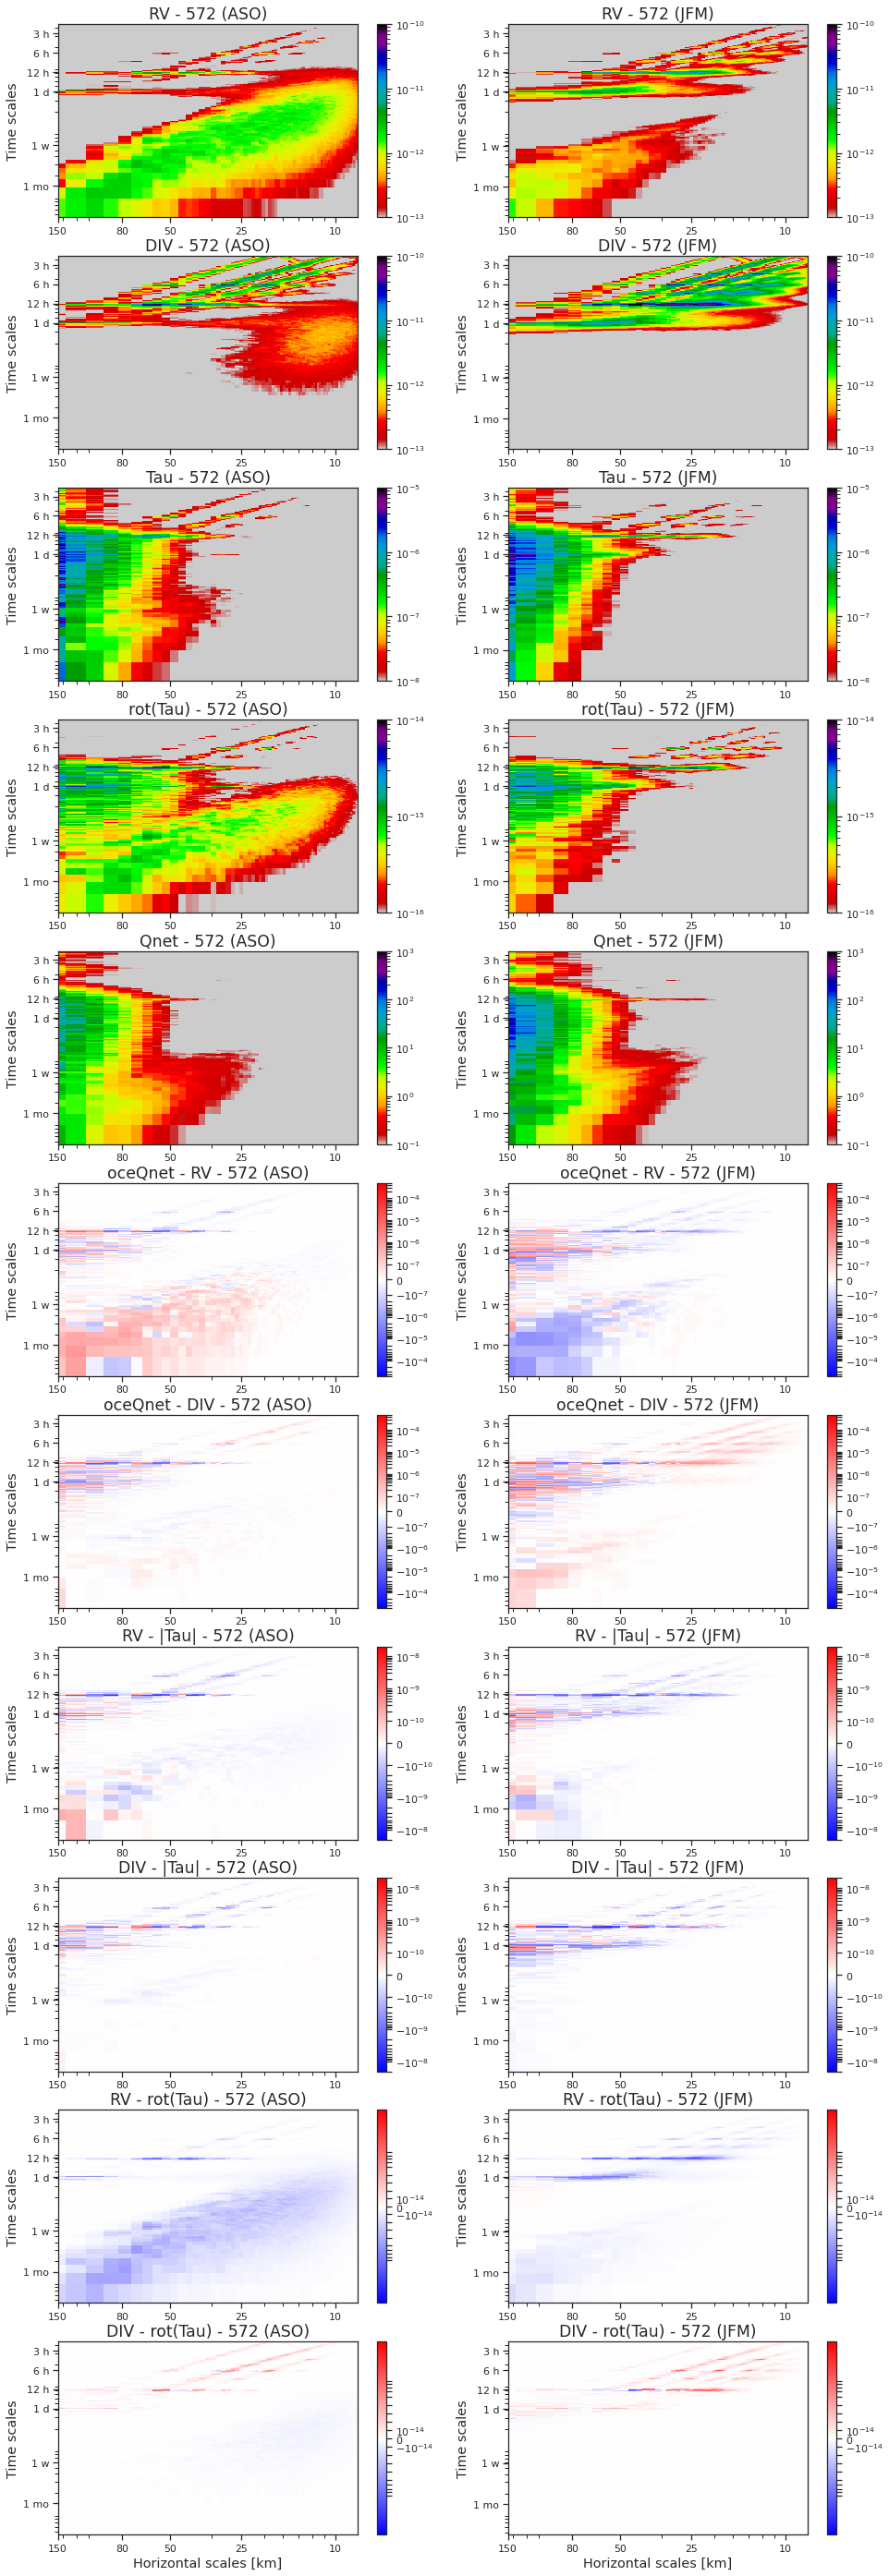

Plotting: 533 ASO


2021-01-28 19:45:31 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902820921527778 km, dt = 1 h
2021-01-28 19:45:31 INFO     Exists? 533: _ASO -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/533_ASO_hours.npz
2021-01-28 19:45:32 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-01-28 19:45:32 INFO     All spectra - dict_keys(['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec'])
2021-01-28 19:45:33 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/533_ASO_hours.npz: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k'

Plotting: 533 JFM


2021-01-28 19:45:34 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902820921527778 km, dt = 1 h
2021-01-28 19:45:34 INFO     Exists? 533: _JFM -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/533_JFM_hours.npz
2021-01-28 19:45:35 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec']
2021-01-28 19:45:35 INFO     All spectra - dict_keys(['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km', 'Tau_x', 'Tau_y', 'Tau', 'Tau_norm', 'Tau_curl', 'RV', 'DIV', 'Qnet', 'Qnet_RV_cospec', 'Qnet_DIV_cospec', 'Tau_RV_cospec', 'Tau_DIV_cospec', 'rotTau_RV_cospec', 'rotTau_DIV_cospec'])
2021-01-28 19:45:36 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/533_JFM_hours.npz: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k'

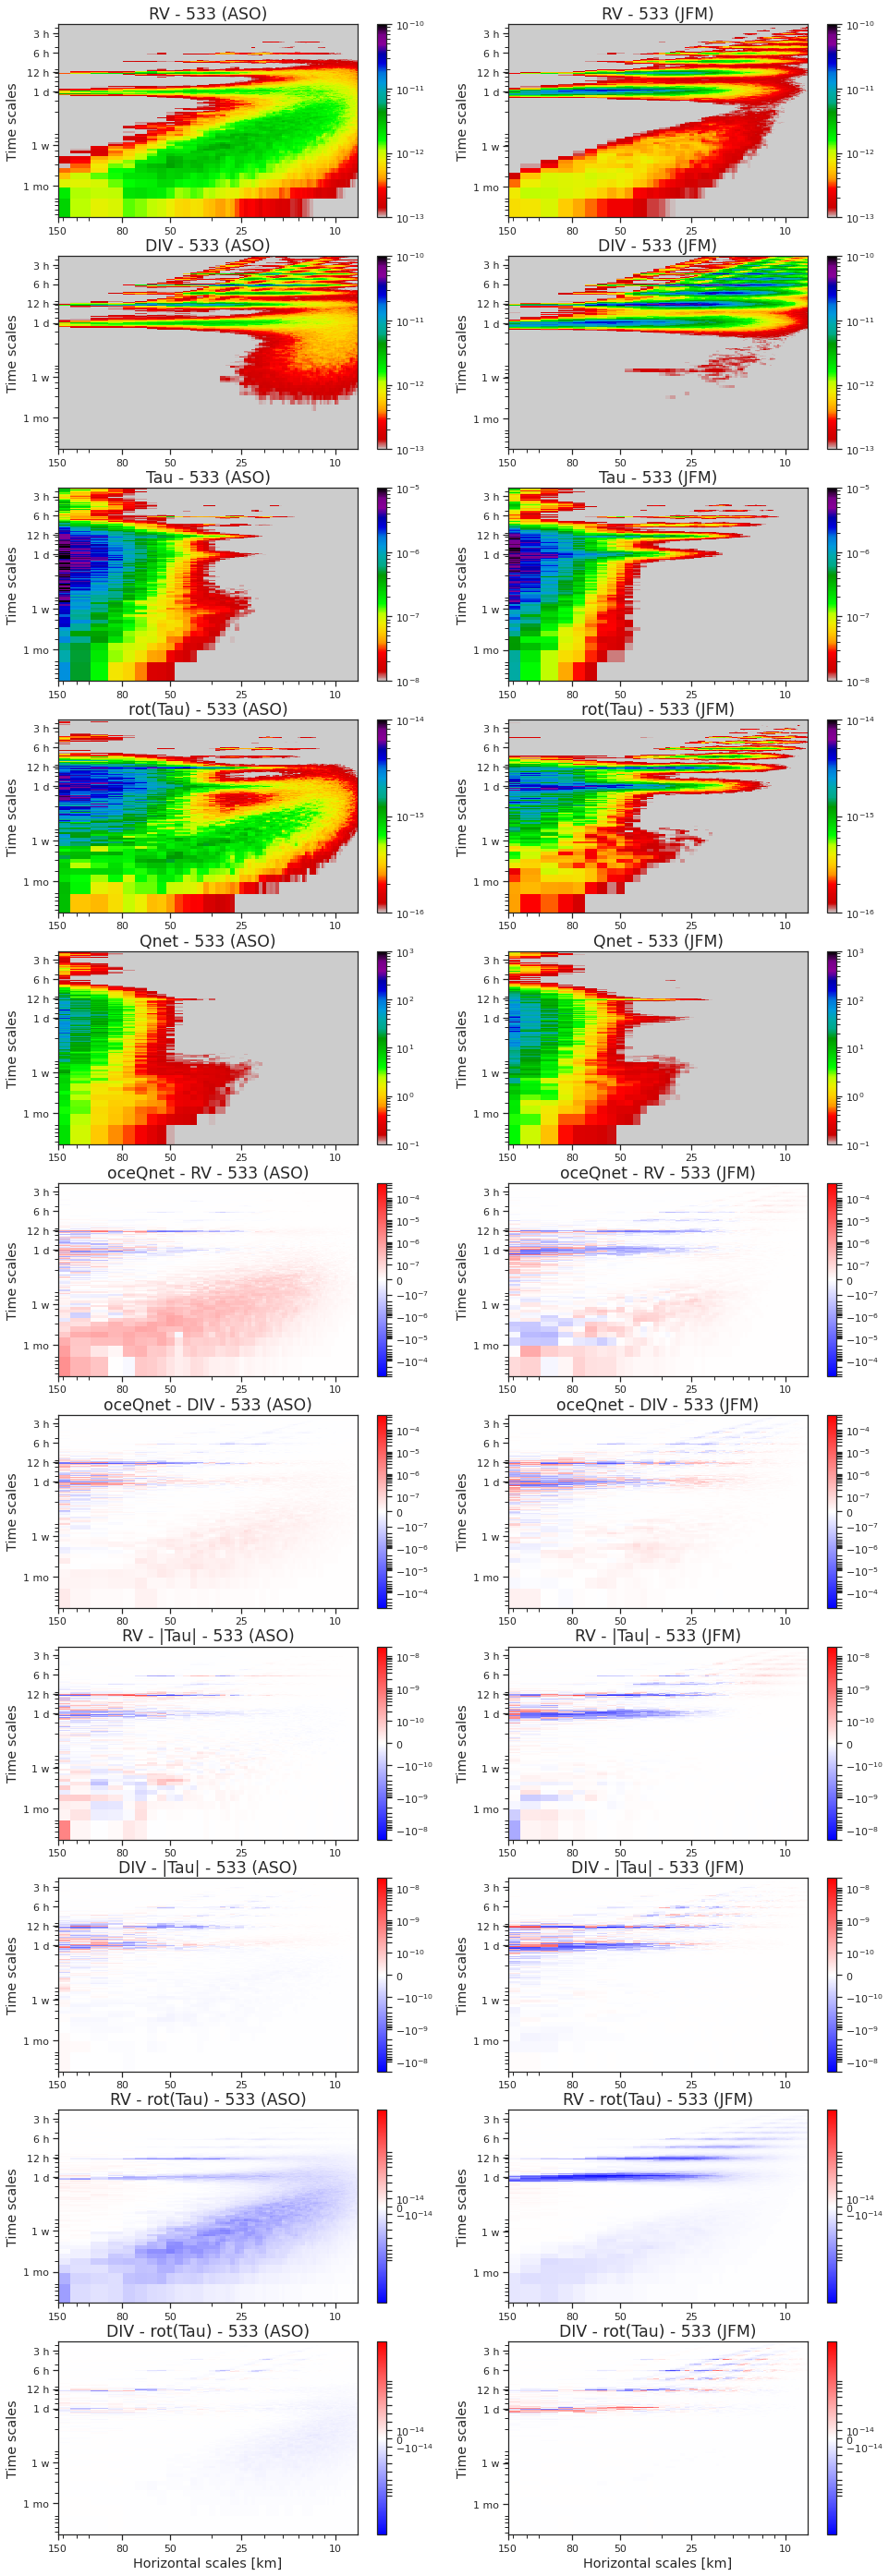

In [11]:
calc_cospectra("California")
calc_cospectra("Canarias")
calc_cospectra("Peru")
calc_cospectra("Benguela")